<h1 align="center"> Auto insurance -  Predicting the total cost & the insurance premium of material claims - Modelling </h1>


In this notebook, after exploring the dataset, we aim to predict the total cost of third-party material claims in order to estimate the insurance premium.

We attempted two approaches:

* Predicting the total cost of third-party material claims, followed by multiplying the result of the cost predicted by the prediction of the number of third-party material claims (conducted in another notebook).

* Predicting the insurance premium by multiplying the actual total cost of third-party material claims by the actual number of third-party material claims and then generating predictions.

Both approaches were implemented using various ML algorithms such as Random Forest, Linear Regression, SGBoost, and others.

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, MaxAbsScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, r2_score, mean_squared_error, mean_absolute_error
import scipy.stats
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.svm import SVR
from xgboost import XGBRegressor
from category_encoders import CountEncoder, TargetEncoder
import shap
from sklearn.neural_network import MLPRegressor

## Goal of the project : 
The objective of calculating an annual third-party premium (material + bodily) for the 36,311 contracts in the 2011 pricing dataset :
Indeed, we will determine the cost of third-party insurance for each contract on an annual basis. This premium is intended to cover material and bodily damages caused to third parties in the event of an accident where the insured party is at fault.


#### Step 1. Data cleaning

In [7]:
# Load the training dataset
training_data = pd.read_csv('training_clean.csv')

In [8]:
# Display the first rows of the training dataset to understand its structure
print("Training Dataset:")
training_data.head()

Training Dataset:


,PolNum,CalYear,Gender,Type,Category,Occupation,Age,Group1,Bonus,Poldur,Value,Adind,SubGroup2,Group2,Density,Exppdays,Numtppd,Numtpbi,Indtppd,Indtpbi
0,200114978,2009,Male,C,Large,Employed,25,18,85,3,15080.0,0,L46,L,72.012883,365.0,1,0,0.0,0.0
1,200114994,2009,Male,E,Large,Employed,20,11,30,2,22370.0,1,O38,O,39.550411,365.0,1,0,0.0,0.0
2,200115001,2009,Female,E,Large,Unemployed,42,11,85,0,39650.0,0,Q28,Q,169.529148,365.0,2,0,0.0,0.0
3,200115011,2009,Female,C,Medium,Housewife,21,5,0,0,12600.0,1,L6,L,58.894688,365.0,1,0,0.0,0.0
4,200115015,2009,Female,D,Large,Employed,33,12,30,10,9065.0,0,N4,N,109.631885,365.0,2,0,0.0,0.0


The training dataset contains:

100,000 unique insurance contracts for the years 2009 and 2010e:
Here is a description of each column in the dataset.

| Column     | Description                                                                  |
|------------|------------------------------------------------------------------------------|
| PolNum     | Contract number                                                              |
| CalYear    | Subscription year                                                            |
| Gender     | Gender of the vehicle driver                                                 |
| Type       | Type of car                                                                  |
| Category   | Car category                                                                 |
| Occupation | Driver's occupation                                                          |
| Age        | Driver's age                                                                 |
| Group1     | Car group                                                                    |
| Bonus      | Bonus-Malus (a discount or surcharge applied based on the claims history)   |
| Poldur     | Age of the insurance contract                                                |
| Value      | Value of the insured vehicle                                                 |
| Adind      | Indicator for material coverage                                              |
| SubGroup2  | Driver's home sub-region                                                     |
| Group2     | Driver's home region                                                         |
| Density    | Population density                                                           |
| Expdays    | Exposure (in days)                                                           |
| Numtppd    | Number of third-party material claims                                        |
| Numtpbi    | Number of third-party bodily injury claims                                   |
| Indtppd    | Total cost of third-party material claims                                    |
| Indtpbi    | Total cost of third-party bodily injury claims                               |


In [9]:
# Get general information on the dataset (ncol, nrow, nbr missing values, dtypes)
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99979 entries, 0 to 99978
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   PolNum      99979 non-null  int64  
 1   CalYear     99979 non-null  int64  
 2   Gender      99979 non-null  object 
 3   Type        99979 non-null  object 
 4   Category    99979 non-null  object 
 5   Occupation  99979 non-null  object 
 6   Age         99979 non-null  int64  
 7   Group1      99979 non-null  int64  
 8   Bonus       99979 non-null  int64  
 9   Poldur      99979 non-null  int64  
 10  Value       99979 non-null  float64
 11  Adind       99979 non-null  int64  
 12  SubGroup2   99979 non-null  object 
 13  Group2      99979 non-null  object 
 14  Density     99979 non-null  float64
 15  Exppdays    99979 non-null  float64
 16  Numtppd     99979 non-null  int64  
 17  Numtpbi     99979 non-null  int64  
 18  Indtppd     99979 non-null  float64
 19  Indtpbi     99979 non-nul

In [10]:
# Check for missing values in the training dataset
print("\nMissing Values in Training Dataset:")
print(training_data.isnull().sum())


Missing Values in Training Dataset:
PolNum        0
CalYear       0
Gender        0
Type          0
Category      0
Occupation    0
Age           0
Group1        0
Bonus         0
Poldur        0
Value         0
Adind         0
SubGroup2     0
Group2        0
Density       0
Exppdays      0
Numtppd       0
Numtpbi       0
Indtppd       0
Indtpbi       0
dtype: int64


In [11]:
# Summary statistics of the training dataset
print("\nSummary Statistics of Training Dataset:")
training_data.describe()


Summary Statistics of Training Dataset:


,PolNum,CalYear,Age,Group1,Bonus,Poldur,Value,Adind,Density,Exppdays,Numtppd,Numtpbi,Indtppd,Indtpbi
count,9.997900e+04,99979.000000,99979.000000,99979.000000,99979.000000,99979.000000,99979.000000,99979.000000,99979.000000,99979.000000,99979.000000,99979.000000,99979.000000,99979.000000
mean,2.002003e+08,2009.499935,41.124126,10.691725,-9.374319,5.470579,16358.767416,0.512178,117.142810,349.821137,0.147391,0.046780,106.110750,222.793486
std,6.217119e+04,0.500002,14.301168,4.687371,42.481030,4.591067,10253.792535,0.499854,79.493407,26.019809,0.436855,0.219528,444.979787,1859.763345
min,2.001149e+08,2009.000000,18.000000,1.000000,-50.000000,0.000000,1000.000000,0.000000,14.377142,302.500000,0.000000,0.000000,0.000000,0.000000
25%,2.001399e+08,2009.000000,30.000000,7.000000,-40.000000,1.000000,8380.000000,0.000000,50.566406,340.000000,0.000000,0.000000,0.000000,0.000000
50%,2.001649e+08,2009.000000,40.000000,11.000000,-30.000000,4.000000,14605.000000,1.000000,94.364623,365.000000,0.000000,0.000000,0.000000,0.000000
75%,2.002608e+08,2010.000000,51.000000,14.000000,10.000000,9.000000,22565.000000,1.000000,174.644525,365.000000,0.000000,0.000000,0.000000,0.000000
max,2.002858e+08,2010.000000,75.000000,20.000000,85.000000,15.000000,43842.500000,1.000000,297.385170,365.000000,7.000000,3.000000,12878.369910,69068.026292


In [12]:
# Select only the numeric columns for correlation calculation
numeric_data = training_data.select_dtypes(include='number')

# Calculate the correlation between numeric columns
corr = numeric_data.corr()

# Display the correlation matrix
corr

,PolNum,CalYear,Age,Group1,Bonus,Poldur,Value,Adind,Density,Exppdays,Numtppd,Numtpbi,Indtppd,Indtpbi
PolNum,1.000000,0.972664,0.002436,0.004251,-0.005043,-0.003839,-0.003455,0.001786,0.008234,-0.000613,0.016105,0.001248,0.016661,0.007752
CalYear,0.972664,1.000000,0.001772,0.003736,-0.004583,-0.002483,-0.003646,0.001794,0.008792,-0.001321,0.016163,-0.000018,0.017005,0.007686
Age,0.002436,0.001772,1.000000,0.090984,-0.240476,0.050505,0.018009,0.203077,0.003178,0.000702,-0.162977,-0.097232,-0.137944,-0.054483
Group1,0.004251,0.003736,0.090984,1.000000,-0.025149,0.004468,0.233053,0.020499,0.004397,0.003376,0.091433,0.026593,0.059905,0.002923
Bonus,-0.005043,-0.004583,-0.240476,-0.025149,1.000000,-0.009795,-0.004522,-0.048566,-0.004451,-0.000966,0.232109,0.072716,0.140836,0.038668
Poldur,-0.003839,-0.002483,0.050505,0.004468,-0.009795,1.000000,0.002160,0.012514,-0.001126,0.000556,-0.043410,-0.007581,-0.031188,-0.004157
Value,-0.003455,-0.003646,0.018009,0.233053,-0.004522,0.002160,1.000000,0.008062,0.001496,-0.000369,0.023835,0.007678,0.015609,0.001757
Adind,0.001786,0.001794,0.203077,0.020499,-0.048566,0.012514,0.008062,1.000000,0.003238,0.001833,-0.052193,-0.039510,-0.059232,-0.020369
Density,0.008234,0.008792,0.003178,0.004397,-0.004451,-0.001126,0.001496,0.003238,1.000000,-0.002740,0.120872,0.026306,0.105411,0.021309
Exppdays,-0.000613,-0.001321,0.000702,0.003376,-0.000966,0.000556,-0.000369,0.001833,-0.002740,1.000000,0.066077,0.043648,0.047665,0.024760


In [13]:
print("Valeurs uniques de la colonne Numtppd:", training_data['Numtppd'].unique())
print("Valeurs uniques de la colonne Numtpbi:", training_data['Numtpbi'].unique())
print("Valeurs uniques de la colonne Indtppd:", training_data['Indtppd'].unique())
print("Valeurs uniques de la colonne Indtpbi:", training_data['Indtpbi'].unique())
print("Valeurs uniques de la colonne Bonus:", training_data['Bonus'].unique())

Valeurs uniques de la colonne Numtppd: [1 2 0 3 4 5 6 7]
Valeurs uniques de la colonne Numtpbi: [0 1 2 3]
Valeurs uniques de la colonne Indtppd: [   0.          740.30229036  207.32365675 ...  546.40798246  822.92046036
 5800.0189068 ]
Valeurs uniques de la colonne Indtpbi: [0.00000000e+00 3.84004453e+03 2.79371442e+03 ... 3.52825919e+00
 1.05603349e+03 1.65076419e+01]
Valeurs uniques de la colonne Bonus: [ 85  30   0  40  80 -20 -40 -30  20  50 -50 -10  10  70  60]


In [14]:
# Select only numeric columns
numeric_cols = training_data.select_dtypes(include=['number'])

# Calculate the 90th percentile for each numeric column
percentile_90 = numeric_cols.quantile(0.9)

# Count the number of values above the 90th percentile in each column
count_above_90 = (numeric_cols > percentile_90).sum()

# Calculate the percentage of values above the 90th percentile in each column
percentage_above_90 = (count_above_90 / len(numeric_cols)) * 100

# Display the percentages
print("Percentage of values above the 90th percentile in each column:")
print(percentage_above_90)

Percentage of values above the 90th percentile in each column:
PolNum      10.000100
CalYear      0.000000
Age          9.535002
Group1       7.822643
Bonus        8.957881
Poldur       7.146501
Value        9.993099
Adind        0.000000
Density      9.696036
Exppdays     0.000000
Numtppd      1.917403
Numtpbi      4.503946
Indtppd     10.000100
Indtpbi      4.503946
dtype: float64


In [15]:
#Analysis of the categorical variables vs potential target variables : 

# Select categorical variables
categorical_vars = ['Gender', 'Type', 'Category', 'Occupation', 'Group2']
target_variable = 'Indtppd'

# Loop through categorical variables
for var in categorical_vars:
    # Chi-squared test
    table = pd.crosstab(training_data[target_variable], training_data[var])
    chi2_stat, p_value, _, _ = scipy.stats.chi2_contingency(table)
    print(f"Chi-squared test result for {var} and {target_variable}: p-value = {p_value}")
    
    # Cramer's V calculation
    cramer_v = np.sqrt(chi2_stat / len(training_data))
    print(f"Cramer's V for {var} and {target_variable}: {cramer_v}")

Chi-squared test result for Gender and Indtppd: p-value = 0.9999854740534555
Cramer's V for Gender and Indtppd: 0.3406626443450569
Chi-squared test result for Type and Indtppd: p-value = 1.875032137823681e-22
Cramer's V for Type and Indtppd: 0.8043150408995365
Chi-squared test result for Category and Indtppd: p-value = 0.009223793692081771
Cramer's V for Category and Indtppd: 0.5002183398907641
Chi-squared test result for Occupation and Indtppd: p-value = 1.0
Cramer's V for Occupation and Indtppd: 0.6804423712456945
Chi-squared test result for Group2 and Indtppd: p-value = 1.0
Cramer's V for Group2 and Indtppd: 1.0184739098742412


The p-value resulting from the Chi-squared test indicates the statistical significance of the relationship between the target variable and each categorical variable.
And the Cramer's V is as well a statistical measure used to assess the association between categorical variables. Cramer's V ranges from 0 to 1, where 0 indicates no association and 1 indicates a perfect association. It  provides a standardized measure of the strength of association, allowing for easier interpretation and comparison across different studies or datasets.
NB : Group 2 have a strong relationship and at the same time have a high p value which means that the variables can be independent ! 

In [16]:
#  Creating new target variable
training_data['Prime_ppd'] = training_data['Numtppd'] * training_data['Indtppd']

In [17]:
# Select only the numeric columns for correlation calculation
numeric_data = training_data.select_dtypes(include='number')

# Calculate the correlation between numeric columns
corr = numeric_data.corr()

# Display the correlation matrix
corr

,PolNum,CalYear,Age,Group1,Bonus,Poldur,Value,Adind,Density,Exppdays,Numtppd,Numtpbi,Indtppd,Indtpbi,Prime_ppd
PolNum,1.000000,0.972664,0.002436,0.004251,-0.005043,-0.003839,-0.003455,0.001786,0.008234,-0.000613,0.016105,0.001248,0.016661,0.007752,0.013383
CalYear,0.972664,1.000000,0.001772,0.003736,-0.004583,-0.002483,-0.003646,0.001794,0.008792,-0.001321,0.016163,-0.000018,0.017005,0.007686,0.014284
Age,0.002436,0.001772,1.000000,0.090984,-0.240476,0.050505,0.018009,0.203077,0.003178,0.000702,-0.162977,-0.097232,-0.137944,-0.054483,-0.106877
Group1,0.004251,0.003736,0.090984,1.000000,-0.025149,0.004468,0.233053,0.020499,0.004397,0.003376,0.091433,0.026593,0.059905,0.002923,0.053087
Bonus,-0.005043,-0.004583,-0.240476,-0.025149,1.000000,-0.009795,-0.004522,-0.048566,-0.004451,-0.000966,0.232109,0.072716,0.140836,0.038668,0.119747
Poldur,-0.003839,-0.002483,0.050505,0.004468,-0.009795,1.000000,0.002160,0.012514,-0.001126,0.000556,-0.043410,-0.007581,-0.031188,-0.004157,-0.027682
Value,-0.003455,-0.003646,0.018009,0.233053,-0.004522,0.002160,1.000000,0.008062,0.001496,-0.000369,0.023835,0.007678,0.015609,0.001757,0.015588
Adind,0.001786,0.001794,0.203077,0.020499,-0.048566,0.012514,0.008062,1.000000,0.003238,0.001833,-0.052193,-0.039510,-0.059232,-0.020369,-0.045816
Density,0.008234,0.008792,0.003178,0.004397,-0.004451,-0.001126,0.001496,0.003238,1.000000,-0.002740,0.120872,0.026306,0.105411,0.021309,0.091491
Exppdays,-0.000613,-0.001321,0.000702,0.003376,-0.000966,0.000556,-0.000369,0.001833,-0.002740,1.000000,0.066077,0.043648,0.047665,0.024760,0.038237


In [18]:
#Analysis of the categorical variables vs potential target variables : 

# Select categorical variables
categorical_vars = ['Gender', 'Type', 'Category', 'Occupation', 'Group2']
target_variable = 'Prime_ppd'

# Loop through categorical variables
for var in categorical_vars:
    # Chi-squared test
    table = pd.crosstab(training_data[target_variable], training_data[var])
    chi2_stat, p_value, _, _ = scipy.stats.chi2_contingency(table)
    print(f"Chi-squared test result for {var} and {target_variable}: p-value = {p_value}")
    
    # Cramer's V calculation
    cramer_v = np.sqrt(chi2_stat / len(training_data))
    print(f"Cramer's V for {var} and {target_variable}: {cramer_v}")

Chi-squared test result for Gender and Prime_ppd: p-value = 0.9999854740534555
Cramer's V for Gender and Prime_ppd: 0.3406626443450569
Chi-squared test result for Type and Prime_ppd: p-value = 1.8750321378233167e-22
Cramer's V for Type and Prime_ppd: 0.8043150408995366
Chi-squared test result for Category and Prime_ppd: p-value = 0.009223793692081357
Cramer's V for Category and Prime_ppd: 0.5002183398907641
Chi-squared test result for Occupation and Prime_ppd: p-value = 1.0
Cramer's V for Occupation and Prime_ppd: 0.6804423712456945
Chi-squared test result for Group2 and Prime_ppd: p-value = 1.0
Cramer's V for Group2 and Prime_ppd: 1.0184739098742412


#### Step 2. Feature engineering (Data pre-processing)

#### Step A. Predicting the Indtppd: 

In [43]:
# List of column names to select
columns_to_select_Ind = ['Type', 'Category', 'PolNum', 'CalYear', 'Age', 'Adind', 'Density', 'Bonus', 'Exppdays', 'Group1',
                     'Numtpbi', 'Indtpbi', 'Numtppd']


# Select the columns and assign them to X
X_Ind = training_data[columns_to_select_Ind] # features
y_Ind = training_data["Indtppd"] # target variable

In [44]:
# Identification of missing values
X_Ind.isnull().sum()

Type        0
Category    0
PolNum      0
CalYear     0
Age         0
Adind       0
Density     0
Bonus       0
Exppdays    0
Group1      0
Numtpbi     0
Indtpbi     0
Numtppd     0
dtype: int64

In [45]:
# Applying a pipeline on categorical and numerical feature
categorical_features = X_Ind.select_dtypes(include=['object', 'bool']).columns
numerical_features = X_Ind.select_dtypes(exclude=['object', 'bool']).columns

In [46]:
# Handling missing data and normalization of numeric data with MAX Abs Scaler
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),  # Replace missing numeric data by the median
    ("scaler", StandardScaler())])  # Normalization of numeric data after imputing for the missing values

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Not defined')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])  # Handling missing categorical data



In [47]:
# Define the features preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [48]:
# As our target variable can be imbalanced
X_train_Ind, X_test_Ind, y_train_Ind, y_test_Ind = train_test_split(X_Ind, y_Ind, test_size=0.1, random_state=42)

In [49]:
preprocessor.fit(X_train_Ind, y_train_Ind)
X_train_Ind = preprocessor.transform(X_train_Ind)
X_test_Ind = preprocessor.transform(X_test_Ind)

#### Step B. Predicting the Primeppd : 

In [26]:
# List of column names to select
columns_to_select = ['Type', 'Category', 'Age', 'Adind', 'Density', 'Bonus', 'Exppdays', 'Group1',
                     'Numtpbi', 'Indtppd', 'Numtppd', 'Indtpbi']


# Select the columns and assign them to X
X = training_data[columns_to_select] # features
y = training_data["Prime_ppd"] # target variable

In [27]:
# Identification of missing values
X.isnull().sum()

Type        0
Category    0
Age         0
Adind       0
Density     0
Bonus       0
Exppdays    0
Group1      0
Numtpbi     0
Indtppd     0
Numtppd     0
Indtpbi     0
dtype: int64

In [28]:
# Applying a pipeline on categorical and numerical feature
categorical_features = X.select_dtypes(include=['object', 'bool']).columns
numerical_features = X.select_dtypes(exclude=['object', 'bool']).columns

In [29]:
# Handling missing data and normalization of numeric data with MAX Abs Scaler
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),  # Replace missing numeric data by the median
    ("scaler", StandardScaler())])  # Normalization of numeric data after imputing for the missing values

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Not defined')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])  # Handling missing categorical data


In [30]:
# Define the features preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [31]:
# As our target variable can be imbalanced
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [32]:
preprocessor.fit(X_train, y_train)
X_train = preprocessor.transform(X_train)
X_test = preprocessor.transform(X_test)

#### Step 3. Modelling

#### Step A. Predicting the Indtppd : 

#### 1. SVR

SVR Regression Metrics (svr_Ind):
Mean Squared Error (svr_Ind): 97979.98169591853
R-squared Score (svr_Ind): 0.4734331687259502
MAE (svr_Ind):
Train_svr_Ind: 70.64856497746445
Test_svr_Ind: 68.33407925398457
MSE (svr_Ind):
Train_svr_Ind: 105947.76536504939
Test_svr_Ind: 97979.98169591853
RMSE (svr_Ind):
Train_svr_Ind: 325.49618333407443
Test_svr_Ind: 313.0175421536603
R2 SCORE (svr_Ind):
Train_svr_Ind: 0.4684710143632651
Test_svr_Ind: 0.4734331687259502
MAPE - Mean Absolute Percentage Error (svr_Ind):
Train_svr_Ind: inf
Test_svr_Ind: inf


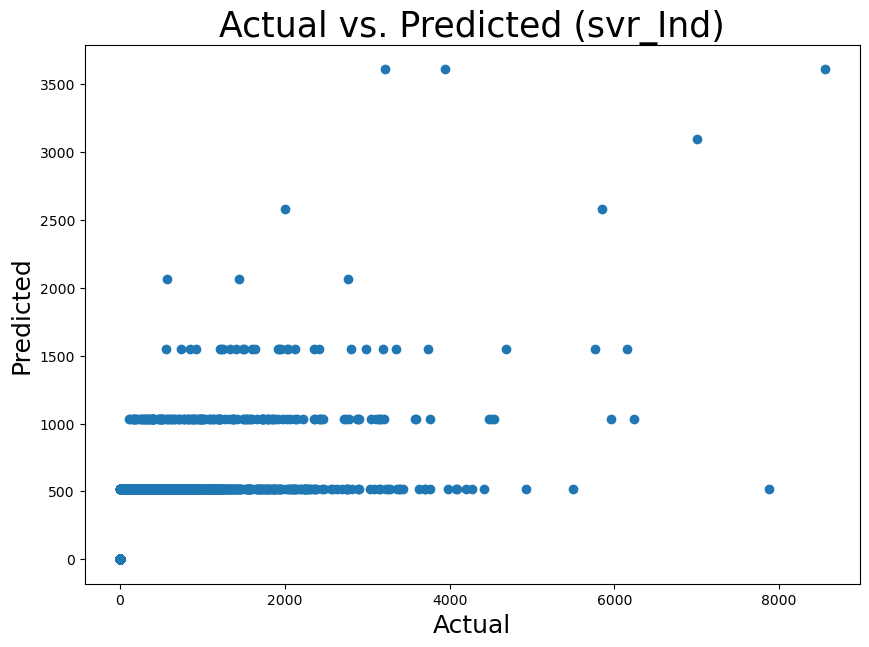

In [26]:
#  Define the SVR model
svr_model = SVR(kernel='linear')

# Train the SVR model
svr_model.fit(X_train_Ind, y_train_Ind)

# Make predictions
y_pred_svr_Ind = svr_model.predict(X_test_Ind)

# Evaluate the model
mse_svr_Ind = mean_squared_error(y_test_Ind, y_pred_svr_Ind)
print("SVR Regression Metrics (svr_Ind):")
print(f"Mean Squared Error (svr_Ind): {mse_svr_Ind}")

r2_svr_Ind = r2_score(y_test_Ind, y_pred_svr_Ind)
print(f"R-squared Score (svr_Ind): {r2_svr_Ind}")

# Predicting on TRAIN & TEST DATA
train_predict_svr_Ind = svr_model.predict(X_train_Ind)
test_predict_svr_Ind = svr_model.predict(X_test_Ind)

# Print MAE (Mean Absolute Error)
print("MAE (svr_Ind):")
print("Train_svr_Ind:", mean_absolute_error(y_train_Ind, train_predict_svr_Ind))
print("Test_svr_Ind:", mean_absolute_error(y_test_Ind, test_predict_svr_Ind))
print("====================================")

# Print MSE (Mean Squared Error)
print("MSE (svr_Ind):")
print("Train_svr_Ind:", mean_squared_error(y_train_Ind, train_predict_svr_Ind))
print("Test_svr_Ind:", mean_squared_error(y_test_Ind, test_predict_svr_Ind))
print("====================================")

# Print RMSE (Root Mean Squared Error)
print("RMSE (svr_Ind):")
print("Train_svr_Ind:", np.sqrt(mean_squared_error(y_train_Ind, train_predict_svr_Ind)))
print("Test_svr_Ind:", np.sqrt(mean_squared_error(y_test_Ind, test_predict_svr_Ind)))
print("====================================")

# Print R2 SCORE
print("R2 SCORE (svr_Ind):")
print("Train_svr_Ind:", r2_score(y_train_Ind, train_predict_svr_Ind))
print("Test_svr_Ind:", r2_score(y_test_Ind, test_predict_svr_Ind))
print("====================================")

# Calculate and print MAPE (Mean Absolute Percentage Error)
mape_train_svr_Ind = np.mean(np.abs((y_train_Ind - train_predict_svr_Ind) / y_train_Ind)) * 100
print("MAPE - Mean Absolute Percentage Error (svr_Ind):")
print("Train_svr_Ind:", mape_train_svr_Ind)
print("Test_svr_Ind:", np.mean(np.abs((y_test_Ind - test_predict_svr_Ind) / y_test_Ind)) * 100)

# Plot actual vs predicted value
plt.figure(figsize=(10, 7))
plt.title("Actual vs. Predicted (svr_Ind)", fontsize=25)
plt.xlabel("Actual", fontsize=18)
plt.ylabel("Predicted", fontsize=18)
plt.scatter(x=y_test_Ind, y=test_predict_svr_Ind)
plt.show()

#### 2. Linear Regression

Intercept (reg_lin): 101.84143169643119
Coefficients (reg_lin): [-1.14423420e+00  3.30221417e+00 -1.07439886e+01 -8.05009075e+00
  7.75663623e+00 -1.47567242e+01 -7.11624708e-01 -2.04219245e+00
  1.46864044e+00  2.82643774e+00  3.23062403e+02  1.83908571e+01
  1.33717815e+01  4.43295713e+00 -8.94494365e+00 -1.15676647e+01
 -1.56829873e+01  2.76674446e+00 -2.32175153e-01 -2.53456930e+00]
MAE_reg_lin_Ind:
Train_reg_lin_Ind: 91.47930065044493
Test_reg_lin_Ind: 90.893775984578
MSE_reg_lin_Ind:
Train_reg_lin_Ind: 95005.97786604657
Test_reg_lin_Ind: 90557.19480333185
RMSE_reg_lin_Ind:
Train_reg_lin_Ind: 308.230397375156
Test_reg_lin_Ind: 300.9272250949253
R2_SCORE_reg_lin_Ind:
Train_reg_lin_Ind: 0.5233648310507499
Test_reg_lin_Ind: 0.5133249232006781
MAPE_reg_lin_Ind - Mean Absolute Percentage Error:
Train_reg_lin_Ind: inf
Test_reg_lin_Ind: inf


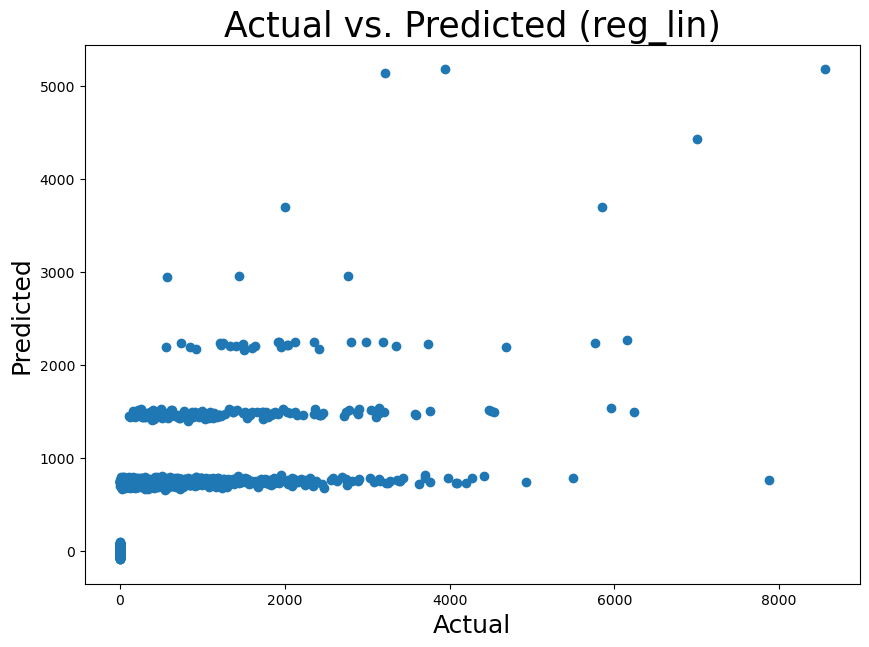

In [27]:
# Instantiate the Linear Regression model
model = LinearRegression()

# Fit the model on the training data
model.fit(X_train_Ind, y_train_Ind)

# Print intercept and coefficients
print("Intercept (reg_lin):", model.intercept_)
print("Coefficients (reg_lin):", model.coef_)

# Predicting on TRAIN & TEST DATA
train_predict_reg_lin_Ind = model.predict(X_train_Ind)
test_predict_reg_lin_Ind = model.predict(X_test_Ind)

# Print MAE (Mean Absolute Error)
print("MAE_reg_lin_Ind:")
print("Train_reg_lin_Ind:", mean_absolute_error(y_train_Ind, train_predict_reg_lin_Ind))
print("Test_reg_lin_Ind:", mean_absolute_error(y_test_Ind, test_predict_reg_lin_Ind))
print("====================================")

# Print MSE (Mean Squared Error)
print("MSE_reg_lin_Ind:")
print("Train_reg_lin_Ind:", mean_squared_error(y_train_Ind, train_predict_reg_lin_Ind))
print("Test_reg_lin_Ind:", mean_squared_error(y_test_Ind, test_predict_reg_lin_Ind))
print("====================================")

# Print RMSE (Root Mean Squared Error)
print("RMSE_reg_lin_Ind:")
print("Train_reg_lin_Ind:", np.sqrt(mean_squared_error(y_train_Ind, train_predict_reg_lin_Ind)))
print("Test_reg_lin_Ind:", np.sqrt(mean_squared_error(y_test_Ind, test_predict_reg_lin_Ind)))
print("====================================")

# Print R2 SCORE
print("R2_SCORE_reg_lin_Ind:")
print("Train_reg_lin_Ind:", r2_score(y_train_Ind, train_predict_reg_lin_Ind))
print("Test_reg_lin_Ind:", r2_score(y_test_Ind, test_predict_reg_lin_Ind))
print("====================================")

# Calculate and print MAPE (Mean Absolute Percentage Error)
train_y_reg_lin_Ind, train_predict_reg_lin_Ind = np.array(y_train_Ind), np.array(train_predict_reg_lin_Ind)
mape_train_reg_lin_Ind = np.mean(np.abs((train_y_reg_lin_Ind - train_predict_reg_lin_Ind) / train_y_reg_lin_Ind)) * 100
print("MAPE_reg_lin_Ind - Mean Absolute Percentage Error:")
print("Train_reg_lin_Ind:", mape_train_reg_lin_Ind)
print("Test_reg_lin_Ind:", np.mean(np.abs((np.array(y_test_Ind) - np.array(test_predict_reg_lin_Ind)) / np.array(y_test_Ind))) * 100)

# Plot actual vs predicted value
plt.figure(figsize=(10, 7))
plt.title("Actual vs. Predicted (reg_lin)", fontsize=25)
plt.xlabel("Actual", fontsize=18)
plt.ylabel("Predicted", fontsize=18)
plt.scatter(x=y_test_Ind, y=test_predict_reg_lin_Ind)
plt.show()

#### 3. Polynomial Features

Polynomial Regression Metrics (poly_Ind):
Mean Squared Error (poly_Ind): 88700.89974988815
R-squared Score (poly_Ind): 0.5233010773832243
Intercept (poly_Ind): -152334337465.90656
Coefficients (poly_Ind): [-8.16420623e+07 -1.64559683e+11  3.08507993e+11 ...  0.00000000e+00
  0.00000000e+00 -5.70515150e+08]
MAE (poly_Ind):
Train_poly_Ind: 86.2081771765214
Test_poly_Ind: 87.23553256725057
MSE (poly_Ind):
Train_poly_Ind: 86109.21875364773
Test_poly_Ind: 88700.89974988815
RMSE (poly_Ind):
Train_poly_Ind: 293.4437233161543
Test_poly_Ind: 297.82696276510654
R2 SCORE (poly_Ind):
Train_poly_Ind: 0.5679989517438488
Test_poly_Ind: 0.5233010773832243
MAPE - Mean Absolute Percentage Error (poly_Ind):
Train_poly_Ind: inf
Test_poly_Ind: inf


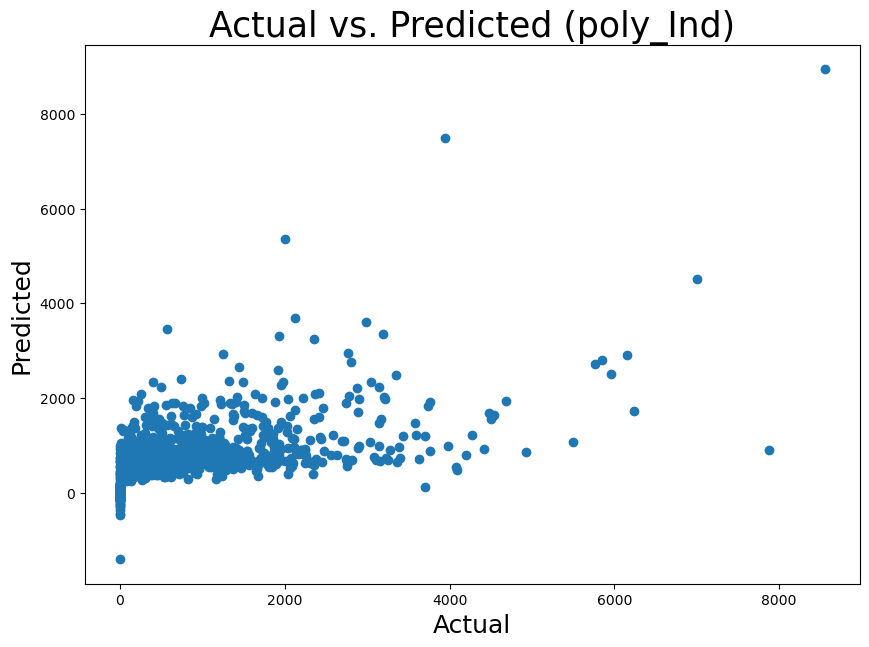

In [28]:
# Define the polynomial regression model
degree = 3  # Degree of the polynomial
poly_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

# Train the polynomial regression model
poly_model.fit(X_train_Ind, y_train_Ind)

# Make predictions
y_pred_poly_Ind = poly_model.predict(X_test_Ind)

# Evaluate the model
mse_poly_Ind = mean_squared_error(y_test_Ind, y_pred_poly_Ind)
print("Polynomial Regression Metrics (poly_Ind):")
print(f"Mean Squared Error (poly_Ind): {mse_poly_Ind}")

r2_poly_Ind = r2_score(y_test_Ind, y_pred_poly_Ind)
print(f"R-squared Score (poly_Ind): {r2_poly_Ind}")

# Calculate other metrics
print("Intercept (poly_Ind):", poly_model.named_steps['linearregression'].intercept_)
print("Coefficients (poly_Ind):", poly_model.named_steps['linearregression'].coef_)

# Predicting on TRAIN & TEST DATA
train_predict_poly_Ind = poly_model.predict(X_train_Ind)
test_predict_poly_Ind = poly_model.predict(X_test_Ind)

# Print MAE (Mean Absolute Error)
print("MAE (poly_Ind):")
print("Train_poly_Ind:", mean_absolute_error(y_train_Ind, train_predict_poly_Ind))
print("Test_poly_Ind:", mean_absolute_error(y_test_Ind, test_predict_poly_Ind))
print("====================================")

# Print MSE (Mean Squared Error)
print("MSE (poly_Ind):")
print("Train_poly_Ind:", mean_squared_error(y_train_Ind, train_predict_poly_Ind))
print("Test_poly_Ind:", mean_squared_error(y_test_Ind, test_predict_poly_Ind))
print("====================================")

# Print RMSE (Root Mean Squared Error)
print("RMSE (poly_Ind):")
print("Train_poly_Ind:", np.sqrt(mean_squared_error(y_train_Ind, train_predict_poly_Ind)))
print("Test_poly_Ind:", np.sqrt(mean_squared_error(y_test_Ind, test_predict_poly_Ind)))
print("====================================")

# Print R2 SCORE
print("R2 SCORE (poly_Ind):")
print("Train_poly_Ind:", r2_score(y_train_Ind, train_predict_poly_Ind))
print("Test_poly_Ind:", r2_score(y_test_Ind, test_predict_poly_Ind))
print("====================================")

# Calculate and print MAPE (Mean Absolute Percentage Error)
mape_train_poly_Ind = np.mean(np.abs((y_train_Ind - train_predict_poly_Ind) / y_train_Ind)) * 100
print("MAPE - Mean Absolute Percentage Error (poly_Ind):")
print("Train_poly_Ind:", mape_train_poly_Ind)
print("Test_poly_Ind:", np.mean(np.abs((y_test_Ind - test_predict_poly_Ind) / y_test_Ind)) * 100)

# Plot actual vs predicted value
plt.figure(figsize=(10, 7))
plt.title("Actual vs. Predicted (poly_Ind)", fontsize=25)
plt.xlabel("Actual", fontsize=18)
plt.ylabel("Predicted", fontsize=18)
plt.scatter(x=y_test_Ind, y=test_predict_poly_Ind)
plt.show()

#### 4. RandomForest with Grid search

Random Forest Regression Metrics (with GridSearchCV) (RF_GSCV_Ind_ppd):
Mean Squared Error (RF_GSCV_Ind_ppd): 85727.27851450977
R-squared Score (RF_GSCV_Ind_ppd): 0.5392819980184407
Best parameters found by GridSearchCV (RF_GSCV_Ind_ppd):
{'regressor__max_depth': 5, 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 10, 'regressor__n_estimators': 1000}
MAE (RF_GSCV_Ind_ppd):
Train_RF_GSCV_Ind_ppd: 72.53978215711174
Test_RF_GSCV_Ind_ppd: 71.8070476610734
MSE (RF_GSCV_Ind_ppd):
Train_RF_GSCV_Ind_ppd: 89238.58801846094
Test_RF_GSCV_Ind_ppd: 85727.27851450977
RMSE (RF_GSCV_Ind_ppd):
Train_RF_GSCV_Ind_ppd: 298.7282845973259
Test_RF_GSCV_Ind_ppd: 292.79221047444173
R2 SCORE (RF_GSCV_Ind_ppd):
Train_RF_GSCV_Ind_ppd: 0.5522992296659195
Test_RF_GSCV_Ind_ppd: 0.5392819980184407
MAPE - Mean Absolute Percentage Error (RF_GSCV_Ind_ppd):
Train_RF_GSCV_Ind_ppd: inf
Test_RF_GSCV_Ind_ppd: 670.6966945865521


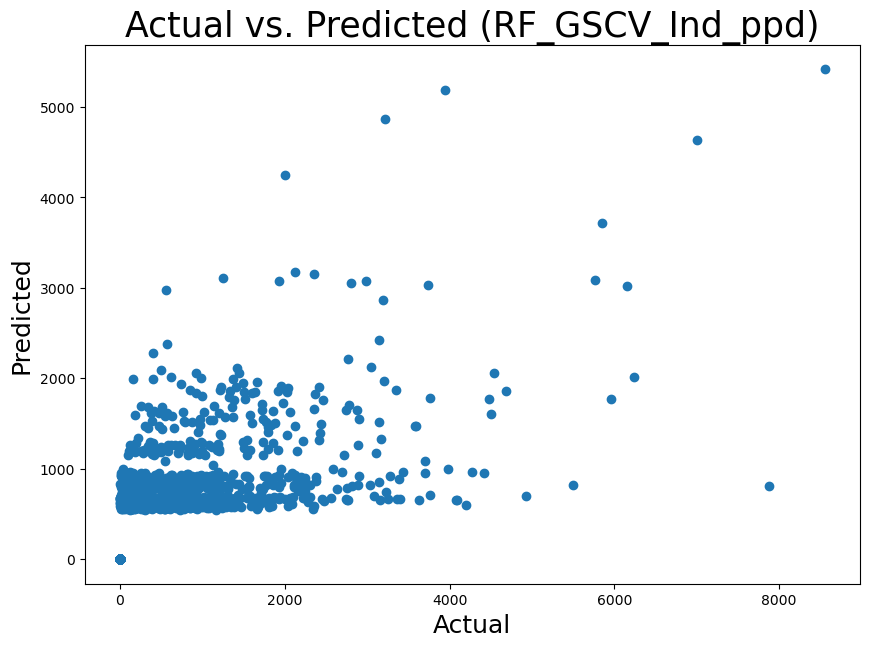

In [41]:
# Define the parameter grid for GridSearchCV
param_grid_RF_GSCV_ppd = {
    'regressor__n_estimators': [1000, 20, 30],  # Number of trees in the forest
    'regressor__max_depth': [None, 5],  # Maximum depth of the tree
    'regressor__min_samples_split': [2, 10],  # Minimum number of samples required to split a node
    'regressor__min_samples_leaf': [1, 2, 4]  # Minimum number of samples required at each leaf node
}

# Define the Random Forest regression model for GridSearchCV
rf_model_RF_GSCV_ppd = RandomForestRegressor(random_state=42)

# Create Pipeline for Random Forest with preprocessing and GridSearchCV
pipeline_RF_GSCV_ppd = Pipeline([
    ('preprocessor', preprocessor),  # Preprocessing steps
    ('regressor', rf_model_RF_GSCV_ppd)  # Random Forest regressor
])

# Configuration et exécution de la recherche sur grille
grid_search_RF_GSCV_ppd = GridSearchCV(estimator=pipeline_RF_GSCV_ppd, param_grid=param_grid_RF_GSCV_ppd, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_RF_GSCV_ppd.fit(X_train_Ind, y_train_Ind)

best_rf_model_RF_GSCV_ppd = grid_search_RF_GSCV_ppd.best_estimator_

# Make predictions
y_pred_rf_grid_Ind_ppd = best_rf_model_RF_GSCV_ppd.predict(X_test_Ind)

# Evaluate the model
mse_rf_grid_Ind_ppd = mean_squared_error(y_test_Ind, y_pred_rf_grid_Ind_ppd)
print("Random Forest Regression Metrics (with GridSearchCV) (RF_GSCV_Ind_ppd):")
print(f"Mean Squared Error (RF_GSCV_Ind_ppd): {mse_rf_grid_Ind_ppd}")

r2_rf_grid_Ind_ppd = r2_score(y_test_Ind, y_pred_rf_grid_Ind_ppd)
print(f"R-squared Score (RF_GSCV_Ind_ppd): {r2_rf_grid_Ind_ppd}")

# Print the best parameters found by GridSearchCV
print("Best parameters found by GridSearchCV (RF_GSCV_Ind_ppd):")
print(grid_search_RF_GSCV_ppd.best_params_)

# Print MAE (Mean Absolute Error)
print("MAE (RF_GSCV_Ind_ppd):")
print("Train_RF_GSCV_Ind_ppd:", mean_absolute_error(y_train_Ind, best_rf_model_RF_GSCV_ppd.predict(X_train_Ind)))
print("Test_RF_GSCV_Ind_ppd:", mean_absolute_error(y_test_Ind, y_pred_rf_grid_Ind_ppd))
print("====================================")

# Print MSE (Mean Squared Error)
print("MSE (RF_GSCV_Ind_ppd):")
print("Train_RF_GSCV_Ind_ppd:", mean_squared_error(y_train_Ind, best_rf_model_RF_GSCV_ppd.predict(X_train_Ind)))
print("Test_RF_GSCV_Ind_ppd:", mse_rf_grid_Ind_ppd)
print("====================================")

# Print RMSE (Root Mean Squared Error)
print("RMSE (RF_GSCV_Ind_ppd):")
print("Train_RF_GSCV_Ind_ppd:", np.sqrt(mean_squared_error(y_train_Ind, best_rf_model_RF_GSCV_ppd.predict(X_train_Ind))))
print("Test_RF_GSCV_Ind_ppd:", np.sqrt(mse_rf_grid_Ind_ppd))
print("====================================")

# Print R2 SCORE
print("R2 SCORE (RF_GSCV_Ind_ppd):")
print("Train_RF_GSCV_Ind_ppd:", r2_score(y_train_Ind, best_rf_model_RF_GSCV_ppd.predict(X_train_Ind)))
print("Test_RF_GSCV_Ind_ppd:", r2_rf_grid_Ind_ppd)
print("====================================")

# Calculate and print MAPE (Mean Absolute Percentage Error)
mape_train_rf_Ind_ppd = np.mean(np.abs((y_train_Ind - best_rf_model_RF_GSCV_ppd.predict(X_train_Ind)) / y_train_Ind)) * 100
print("MAPE - Mean Absolute Percentage Error (RF_GSCV_Ind_ppd):")
print("Train_RF_GSCV_Ind_ppd:", mape_train_rf_Ind_ppd)
print("Test_RF_GSCV_Ind_ppd:", np.mean(np.abs((y_test_Ind - y_pred_rf_grid_Ind_ppd) / y_test_Ind)) * 100)

# Plot actual vs predicted value
plt.figure(figsize=(10, 7))
plt.title("Actual vs. Predicted (RF_GSCV_Ind_ppd)", fontsize=25)
plt.xlabel("Actual", fontsize=18)
plt.ylabel("Predicted", fontsize=18)
plt.scatter(x=y_test_Ind, y=y_pred_rf_grid_Ind_ppd)
plt.show()

#### 5. XGBoost with GridSearch

XGBoost Regression Metrics (with GridSearchCV) - xgb_GSCV_Ind:
Mean Squared Error (xgb_GSCV_Ind): 86542.97683551822
R-squared Score (xgb_GSCV_Ind): 0.534898248677662
Best parameters found by GridSearchCV:
{'learning_rate': 0.03, 'max_depth': 2, 'n_estimators': 900}
MAE (xgb_GSCV_Ind):
Train_Ind: 77.981082994962
Test_Ind: 77.93322150118672
MSE (xgb_GSCV_Ind):
Train_Ind: 87376.09706843052
Test_Ind: 86542.97683551822
RMSE (xgb_GSCV_Ind):
Train_Ind: 295.59448078140855
Test_Ind: 294.18187713643783
R2 SCORE (xgb_GSCV_Ind):
Train_Ind: 0.5616431542122869
Test_Ind: 0.534898248677662
MAPE - Mean Absolute Percentage Error (xgb_GSCV_Ind):
Train_Ind: inf
Test_Ind: inf


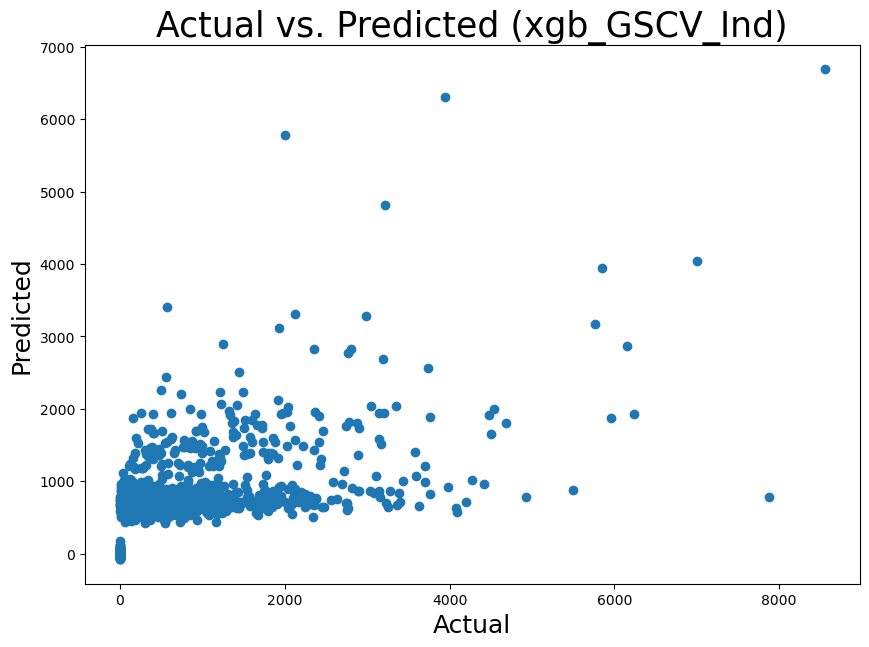

In [50]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators':  [700, 800, 900],  # Number of boosting rounds
    'max_depth': [2, 4, 6], # Maximum depth of the tree
    'learning_rate': [0.01, 0.02, 0.03]  # Step size shrinkage used in update to prevents overfitting
}

# Define the XGBoost regression model
xgb_model = XGBRegressor(random_state=42)

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Perform grid search
grid_search.fit(X_train_Ind, y_train_Ind)

# Get the best model
best_xgb_model = grid_search.best_estimator_

# Make predictions
y_pred_xgb_grid_Ind = best_xgb_model.predict(X_test_Ind)

# Evaluate the model
mse_xgb_grid_Ind = mean_squared_error(y_test_Ind, y_pred_xgb_grid_Ind)
print("XGBoost Regression Metrics (with GridSearchCV) - xgb_GSCV_Ind:")
print(f"Mean Squared Error (xgb_GSCV_Ind): {mse_xgb_grid_Ind}")

r2_xgb_grid_Ind = r2_score(y_test_Ind, y_pred_xgb_grid_Ind)
print(f"R-squared Score (xgb_GSCV_Ind): {r2_xgb_grid_Ind}")

# Print the best parameters found by GridSearchCV
print("Best parameters found by GridSearchCV:")
print(grid_search.best_params_)

# Print MAE (Mean Absolute Error)
print("MAE (xgb_GSCV_Ind):")
print("Train_Ind:", mean_absolute_error(y_train_Ind, best_xgb_model.predict(X_train_Ind)))
print("Test_Ind:", mean_absolute_error(y_test_Ind, y_pred_xgb_grid_Ind))
print("====================================")

# Print MSE (Mean Squared Error)
print("MSE (xgb_GSCV_Ind):")
print("Train_Ind:", mean_squared_error(y_train_Ind, best_xgb_model.predict(X_train_Ind)))
print("Test_Ind:", mse_xgb_grid_Ind)
print("====================================")

# Print RMSE (Root Mean Squared Error)
print("RMSE (xgb_GSCV_Ind):")
print("Train_Ind:", np.sqrt(mean_squared_error(y_train_Ind, best_xgb_model.predict(X_train_Ind))))
print("Test_Ind:", np.sqrt(mse_xgb_grid_Ind))
print("====================================")

# Print R2 SCORE
print("R2 SCORE (xgb_GSCV_Ind):")
print("Train_Ind:", r2_score(y_train_Ind, best_xgb_model.predict(X_train_Ind)))
print("Test_Ind:", r2_xgb_grid_Ind)
print("====================================")

# Calculate and print MAPE (Mean Absolute Percentage Error)
mape_train_xgb_Ind = np.mean(np.abs((y_train_Ind - best_xgb_model.predict(X_train_Ind)) / y_train_Ind)) * 100
print("MAPE - Mean Absolute Percentage Error (xgb_GSCV_Ind):")
print("Train_Ind:", mape_train_xgb_Ind)
print("Test_Ind:", np.mean(np.abs((y_test_Ind - y_pred_xgb_grid_Ind) / y_test_Ind)) * 100)

# Plot actual vs predicted value
plt.figure(figsize=(10, 7))
plt.title("Actual vs. Predicted (xgb_GSCV_Ind)", fontsize=25)
plt.xlabel("Actual", fontsize=18)
plt.ylabel("Predicted", fontsize=18)
plt.scatter(x=y_test_Ind, y=y_pred_xgb_grid_Ind)
plt.show()


#### 6. MLP regressor

MAE (MLP_Ind):
Train_MLP_Ind: 78.63129772680828
Test_MLP_Ind: 79.81832766718385
MSE (MLP_Ind):
Train_MLP_Ind: 85683.52561111654
Test_MLP_Ind: 87224.55485279423
RMSE (MLP_Ind):
Train_MLP_Ind: 292.7174842935019
Test_MLP_Ind: 295.3380348901818
R2 SCORE (MLP_Ind):
Train_MLP_Ind: 0.5701346102304861
Test_MLP_Ind: 0.5312352925246704
MAPE - Mean Absolute Percentage Error (MLP_Ind):
Train_MLP_Ind: inf
Test_MLP_Ind: inf


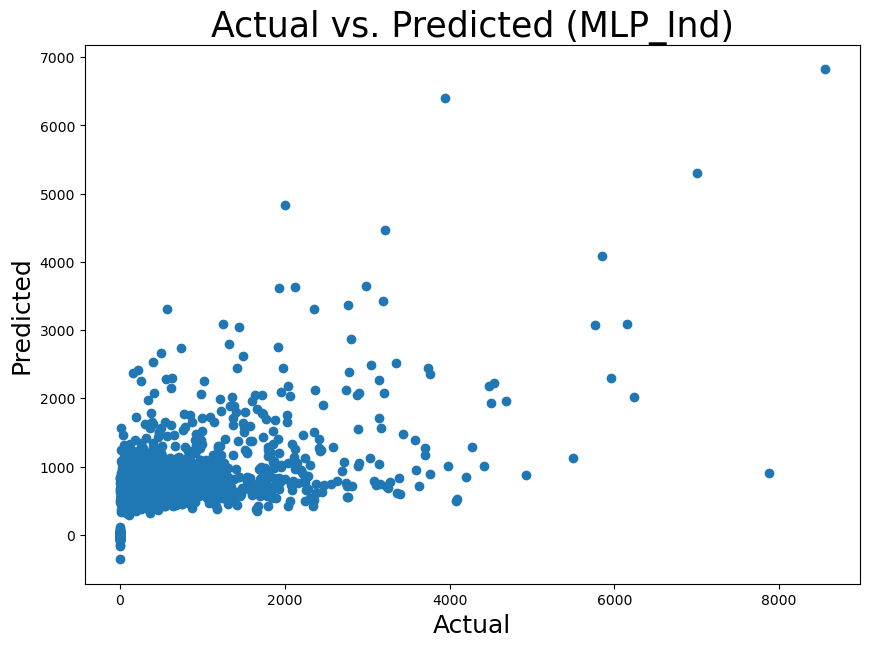

In [51]:
# Define the MLP regressor
mlp_regressor = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', 
                             alpha=0.0001, batch_size='auto', learning_rate='constant', 
                             learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True, 
                             random_state=42, tol=0.0001, verbose=False, warm_start=False, 
                             momentum=0.9, nesterovs_momentum=True, early_stopping=False, 
                             validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, 
                             n_iter_no_change=10, max_fun=15000)

# Fit the MLP regressor
mlp_regressor.fit(X_train_Ind, y_train_Ind)

# Make predictions
train_predict_mlp_Ind = mlp_regressor.predict(X_train_Ind)
test_predict_mlp_Ind = mlp_regressor.predict(X_test_Ind)

# Print evaluation metrics
print("MAE (MLP_Ind):")
print("Train_MLP_Ind:", mean_absolute_error(y_train_Ind, train_predict_mlp_Ind))
print("Test_MLP_Ind:", mean_absolute_error(y_test_Ind, test_predict_mlp_Ind))
print("====================================")

print("MSE (MLP_Ind):")
print("Train_MLP_Ind:", mean_squared_error(y_train_Ind, train_predict_mlp_Ind))
print("Test_MLP_Ind:", mean_squared_error(y_test_Ind, test_predict_mlp_Ind))
print("====================================")

print("RMSE (MLP_Ind):")
print("Train_MLP_Ind:", np.sqrt(mean_squared_error(y_train_Ind, train_predict_mlp_Ind)))
print("Test_MLP_Ind:", np.sqrt(mean_squared_error(y_test_Ind, test_predict_mlp_Ind)))
print("====================================")

print("R2 SCORE (MLP_Ind):")
print("Train_MLP_Ind:", r2_score(y_train_Ind, train_predict_mlp_Ind))
print("Test_MLP_Ind:", r2_score(y_test_Ind, test_predict_mlp_Ind))
print("====================================")

# Calculate and print MAPE (Mean Absolute Percentage Error)
mape_train_mlp_Ind = np.mean(np.abs((y_train_Ind - train_predict_mlp_Ind) / y_train_Ind)) * 100
print("MAPE - Mean Absolute Percentage Error (MLP_Ind):")
print("Train_MLP_Ind:", mape_train_mlp_Ind)
print("Test_MLP_Ind:", np.mean(np.abs((y_test_Ind - test_predict_mlp_Ind) / y_test_Ind)) * 100)

# Plot actual vs predicted value
plt.figure(figsize=(10, 7))
plt.title("Actual vs. Predicted (MLP_Ind)", fontsize=25)
plt.xlabel("Actual", fontsize=18)
plt.ylabel("Predicted", fontsize=18)
plt.scatter(x=y_test_Ind, y=test_predict_mlp_Ind)
plt.show()

#### Step B. Predicting the Primeppd : 

#### 1. Linear Regression

Intercept (reg_lin_model): 59.58936591740851
Coefficients (reg_lin_model): [ 2.14216222e+00  7.96133268e-01 -8.19170921e-01 -5.00708026e-02
 -5.52538732e-01 -5.78208181e-02 -3.17792308e-01  2.18203406e+02
  3.04643979e+01  1.20503394e+00 -4.34746110e-01 -3.30230798e-01
 -2.06076111e+00  1.24794109e+00  3.23215297e+00 -1.65435604e+00
 -7.90734672e-01  6.53320476e-01  1.37414196e-01]
MAE_reg_lin_model:
Train_reg_lin_model: 26.45106945375991
Test_reg_lin_model: 27.251804845120564
MSE_reg_lin_model:
Train_reg_lin_model: 9252.044242588308
Test_reg_lin_model: 10364.986538079707
RMSE_reg_lin_model:
Train_reg_lin_model: 96.18754723241626
Test_reg_lin_model: 101.80857791993613
R2_SCORE_reg_lin_model:
Train_reg_lin_model: 0.8595161977035296
Test_reg_lin_model: 0.8508020130908809
MAPE_reg_lin_model - Mean Absolute Percentage Error:
Train_reg_lin_model: inf
Test_reg_lin_model: inf


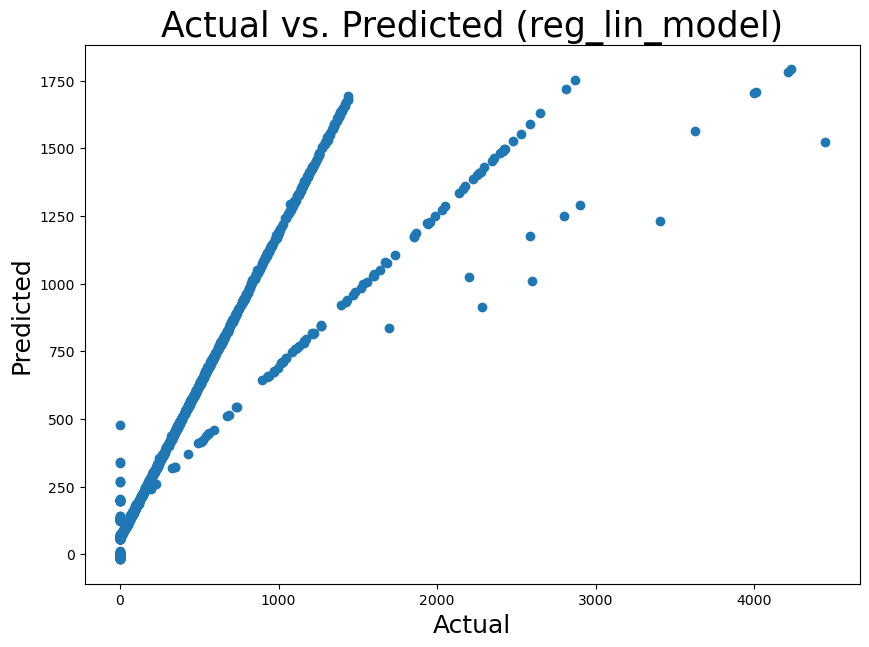

In [101]:
# Instantiate the Linear Regression model
reg_lin_model = LinearRegression()

# Fit the model on the training data
reg_lin_model.fit(X_train, y_train)

# Print intercept and coefficients
print("Intercept (reg_lin_model):", reg_lin_model.intercept_)
print("Coefficients (reg_lin_model):", reg_lin_model.coef_)

# Predicting on TRAIN & TEST DATA
train_predict_reg_lin = reg_lin_model.predict(X_train)
test_predict_reg_lin = reg_lin_model.predict(X_test)

# Print MAE (Mean Absolute Error)
print("MAE_reg_lin_model:")
print("Train_reg_lin_model:", mean_absolute_error(y_train, train_predict_reg_lin))
print("Test_reg_lin_model:", mean_absolute_error(y_test, test_predict_reg_lin))
print("====================================")

# Print MSE (Mean Squared Error)
print("MSE_reg_lin_model:")
print("Train_reg_lin_model:", mean_squared_error(y_train, train_predict_reg_lin))
print("Test_reg_lin_model:", mean_squared_error(y_test, test_predict_reg_lin))
print("====================================")

# Print RMSE (Root Mean Squared Error)
print("RMSE_reg_lin_model:")
print("Train_reg_lin_model:", np.sqrt(mean_squared_error(y_train, train_predict_reg_lin)))
print("Test_reg_lin_model:", np.sqrt(mean_squared_error(y_test, test_predict_reg_lin)))
print("====================================")

# Print R2 SCORE
print("R2_SCORE_reg_lin_model:")
print("Train_reg_lin_model:", r2_score(y_train, train_predict_reg_lin))
print("Test_reg_lin_model:", r2_score(y_test, test_predict_reg_lin))
print("====================================")

# Calculate and print MAPE (Mean Absolute Percentage Error)
train_y_reg_lin, train_predict_reg_lin = np.array(y_train), np.array(train_predict_reg_lin)
mape_train_reg_lin = np.mean(np.abs((train_y_reg_lin - train_predict_reg_lin) / train_y_reg_lin)) * 100
print("MAPE_reg_lin_model - Mean Absolute Percentage Error:")
print("Train_reg_lin_model:", mape_train_reg_lin)
print("Test_reg_lin_model:", np.mean(np.abs((np.array(y_test) - np.array(test_predict_reg_lin)) / np.array(y_test))) * 100)

# Plot actual vs predicted value
plt.figure(figsize=(10, 7))
plt.title("Actual vs. Predicted (reg_lin_model)", fontsize=25)
plt.xlabel("Actual", fontsize=18)
plt.ylabel("Predicted", fontsize=18)
plt.scatter(x=y_test, y=test_predict_reg_lin)
plt.show()


#### 2. Polynomial Features

Polynomial Regression Metrics:
Mean Squared Error: 1.1032174730388242e-23
R-squared Score: 1.0
Intercept (poly_model): 396.1679598614303
Coefficients (poly_model): [-5.82689220e-03  1.22868561e+00 -1.60478505e+01 -1.15138769e-01
 -1.80984131e+00 -8.72157049e-01  1.36032483e-01  2.15138498e-01
  2.55532033e+01  1.90470129e+01  1.41525914e+00 -1.47477450e-02
 -9.82328261e-02  2.62159256e-02 -7.69035252e-02 -1.47175277e-01
  3.56773683e-02 -1.01953832e-01  1.11132771e-03 -1.40550270e-01
  5.20694599e-14 -3.10862447e-14 -3.55271368e-15 -3.37507799e-14
 -7.49816875e-14 -4.26325641e-14  0.00000000e+00  5.95079541e-14
 -3.35287353e-14  3.99680289e-14  2.00999821e-01  2.00999821e-01
  2.00999821e-01  2.00999821e-01  2.00999821e-01  2.00999821e-01
 -1.42968543e+00 -1.42968543e+00 -1.42968543e+00 -3.88487994e+02
  2.66453526e-14  7.46069873e-14 -2.88657986e-14  2.93098879e-14
  5.37347944e-14 -8.59312621e-14 -1.37667655e-14  4.50750548e-14
 -2.78976242e+00 -2.78976242e+00 -2.78976242e+00 -2.7897

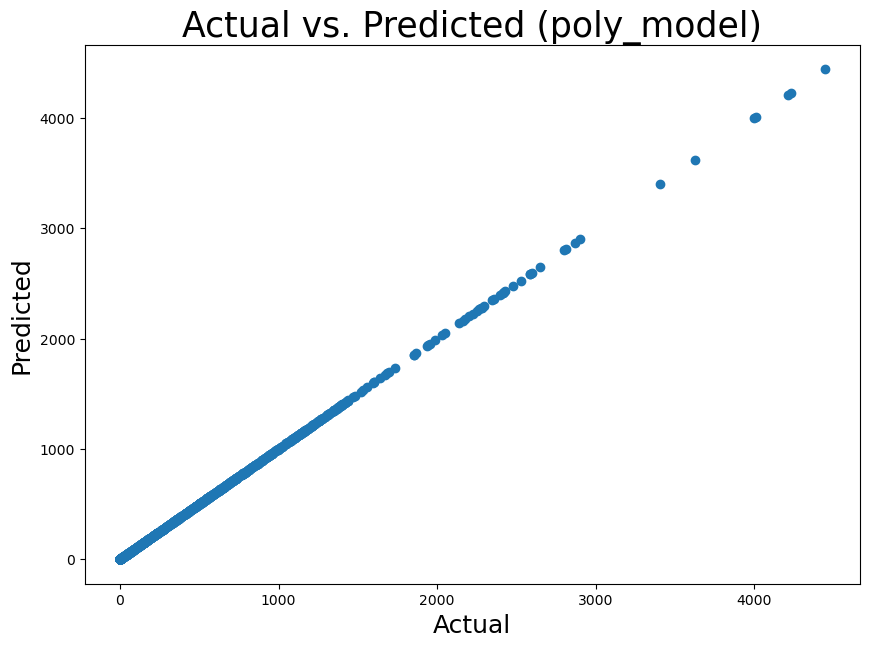

In [102]:
# Define the polynomial regression model
degree = 2  # Degree of the polynomial
poly_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

# Train the polynomial regression model
poly_model.fit(X_train, y_train)

# Make predictions
y_pred_poly = poly_model.predict(X_test)

# Evaluate the model
mse_poly = mean_squared_error(y_test, y_pred_poly)
print("Polynomial Regression Metrics:")
print(f"Mean Squared Error: {mse_poly}")

r2_poly = r2_score(y_test, y_pred_poly)
print(f"R-squared Score: {r2_poly}")

# Calculate other metrics
print("Intercept (poly_model):", poly_model.named_steps['linearregression'].intercept_)
print("Coefficients (poly_model):", poly_model.named_steps['linearregression'].coef_)

# Predicting on TRAIN & TEST DATA
train_predict_poly = poly_model.predict(X_train)
test_predict_poly = poly_model.predict(X_test)

# Print MAE (Mean Absolute Error)
print("MAE_poly_model:")
print("Train_poly_model:", mean_absolute_error(y_train, train_predict_poly))
print("Test_poly_model:", mean_absolute_error(y_test, test_predict_poly))
print("====================================")

# Print MSE (Mean Squared Error)
print("MSE_poly_model:")
print("Train_poly_model:", mean_squared_error(y_train, train_predict_poly))
print("Test_poly_model:", mean_squared_error(y_test, test_predict_poly))
print("====================================")

# Print RMSE (Root Mean Squared Error)
print("RMSE_poly_model:")
print("Train_poly_model:", np.sqrt(mean_squared_error(y_train, train_predict_poly)))
print("Test_poly_model:", np.sqrt(mean_squared_error(y_test, test_predict_poly)))
print("====================================")

# Print R2 SCORE
print("R2_SCORE_poly_model:")
print("Train_poly_model:", r2_score(y_train, train_predict_poly))
print("Test_poly_model:", r2_score(y_test, test_predict_poly))
print("====================================")

# Calculate and print MAPE (Mean Absolute Percentage Error)
train_y_poly, train_predict_poly = np.array(y_train), np.array(train_predict_poly)
mape_train_poly = np.mean(np.abs((train_y_poly - train_predict_poly) / train_y_poly)) * 100
print("MAPE_poly_model - Mean Absolute Percentage Error:")
print("Train_poly_model:", mape_train_poly)
print("Test_poly_model:", np.mean(np.abs((np.array(y_test) - np.array(test_predict_poly)) / np.array(y_test))) * 100)

# Plot actual vs predicted value
plt.figure(figsize=(10, 7))
plt.title("Actual vs. Predicted (poly_model)", fontsize=25)
plt.xlabel("Actual", fontsize=18)
plt.ylabel("Predicted", fontsize=18)
plt.scatter(x=y_test, y=test_predict_poly)
plt.show()



#### 3. SVR

SVR Regression Metrics:
Mean Squared Error: 9417.553001439604
R-squared Score: 0.9554235377243832
MAE:
Train: 1.6206549145590217
Test: 2.8542857444400327
MSE:
Train: 5694.51646346309
Test: 9417.553001439604
RMSE:
Train: 75.46202000651115
Test: 97.0440776216643
R2 SCORE:
Train: 0.9687297437092127
Test: 0.9554235377243832
MAPE - Mean Absolute Percentage Error:
Train: inf
Test: inf


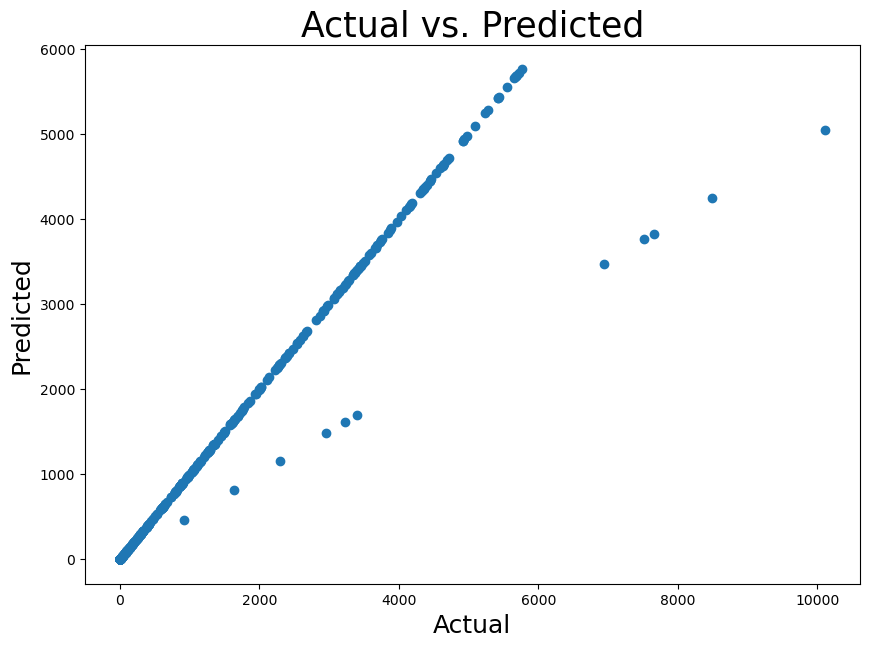

In [51]:
# Define the SVR model
svr_model = SVR(kernel='linear')

# Train the SVR model
svr_model.fit(X_train, y_train)

# Make predictions
y_pred_svr = svr_model.predict(X_test)

# Evaluate the model
mse_svr = mean_squared_error(y_test, y_pred_svr)
print("SVR Regression Metrics:")
print(f"Mean Squared Error (svr_model): {mse_svr}")

r2_svr = r2_score(y_test, y_pred_svr)
print(f"R-squared Score (svr_model): {r2_svr}")

# Predicting on TRAIN & TEST DATA
train_predict_svr = svr_model.predict(X_train)
test_predict_svr = svr_model.predict(X_test)

# Print MAE (Mean Absolute Error)
print("MAE_svr_model:")
print("Train_svr_model:", mean_absolute_error(y_train, train_predict_svr))
print("Test_svr_model:", mean_absolute_error(y_test, test_predict_svr))
print("====================================")

# Print MSE (Mean Squared Error)
print("MSE_svr_model:")
print("Train_svr_model:", mean_squared_error(y_train, train_predict_svr))
print("Test_svr_model:", mean_squared_error(y_test, test_predict_svr))
print("====================================")

# Print RMSE (Root Mean Squared Error)
print("RMSE_svr_model:")
print("Train_svr_model:", np.sqrt(mean_squared_error(y_train, train_predict_svr)))
print("Test_svr_model:", np.sqrt(mean_squared_error(y_test, test_predict_svr)))
print("====================================")

# Print R2 SCORE
print("R2_SCORE_svr_model:")
print("Train_svr_model:", r2_score(y_train, train_predict_svr))
print("Test_svr_model:", r2_score(y_test, test_predict_svr))
print("====================================")

# Calculate and print MAPE (Mean Absolute Percentage Error)
train_y_svr, train_predict_svr = np.array(y_train), np.array(train_predict_svr)
mape_train_svr = np.mean(np.abs((train_y_svr - train_predict_svr) / train_y_svr)) * 100
print("MAPE_svr_model - Mean Absolute Percentage Error:")
print("Train_svr_model:", mape_train_svr)
print("Test_svr_model:", np.mean(np.abs((np.array(y_test) - np.array(test_predict_svr)) / np.array(y_test))) * 100)

# Plot actual vs predicted value
plt.figure(figsize=(10, 7))
plt.title("Actual vs. Predicted (svr_model)", fontsize=25)
plt.xlabel("Actual", fontsize=18)
plt.ylabel("Predicted", fontsize=18)
plt.scatter(x=y_test, y=test_predict_svr)
plt.show()

#### 4. RandomForest

Random Forest Regression Metrics:
Mean Squared Error (rf_model): 134.70706459735734
R-squared Score (rf_model): 0.9980609697092684
MAE_rf_model:
Train_rf_model: 0.047909469817974615
Test_rf_model: 0.2845830117141191
MSE_rf_model:
Train_rf_model: 5.227298479548099
Test_rf_model: 134.70706459735734
RMSE_rf_model:
Train_rf_model: 2.286328602705241
Test_rf_model: 11.606337260193559
R2_SCORE_rf_model:
Train_rf_model: 0.9999206282690732
Test_rf_model: 0.9980609697092684
MAPE_rf_model - Mean Absolute Percentage Error:
Train_rf_model: nan
Test_rf_model: nan


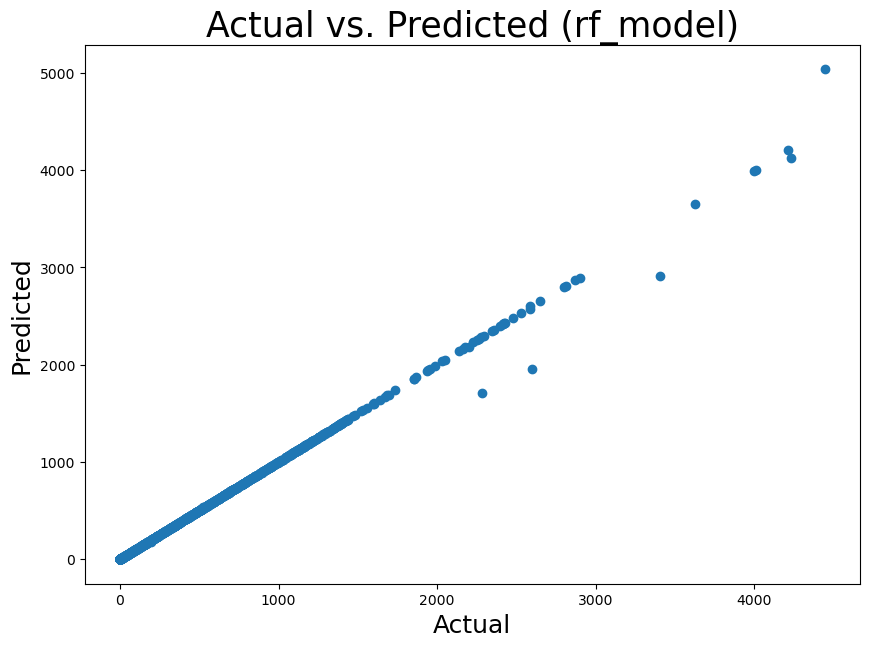

In [103]:
# Define the Random Forest regression model
rf_model = RandomForestRegressor(random_state=42)

# Train the Random Forest regression model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf_model = rf_model.predict(X_test)

# Evaluate the model
mse_rf_model = mean_squared_error(y_test, y_pred_rf_model)
print("Random Forest Regression Metrics:")
print(f"Mean Squared Error (rf_model): {mse_rf_model}")

r2_rf_model = r2_score(y_test, y_pred_rf_model)
print(f"R-squared Score (rf_model): {r2_rf_model}")

# Predicting on TRAIN & TEST DATA
train_predict_rf_model = rf_model.predict(X_train)
test_predict_rf_model = rf_model.predict(X_test)

# Print MAE (Mean Absolute Error)
print("MAE_rf_model:")
print("Train_rf_model:", mean_absolute_error(y_train, train_predict_rf_model))
print("Test_rf_model:", mean_absolute_error(y_test, test_predict_rf_model))
print("====================================")

# Print MSE (Mean Squared Error)
print("MSE_rf_model:")
print("Train_rf_model:", mean_squared_error(y_train, train_predict_rf_model))
print("Test_rf_model:", mean_squared_error(y_test, test_predict_rf_model))
print("====================================")

# Print RMSE (Root Mean Squared Error)
print("RMSE_rf_model:")
print("Train_rf_model:", np.sqrt(mean_squared_error(y_train, train_predict_rf_model)))
print("Test_rf_model:", np.sqrt(mean_squared_error(y_test, test_predict_rf_model)))
print("====================================")

# Print R2 SCORE
print("R2_SCORE_rf_model:")
print("Train_rf_model:", r2_score(y_train, train_predict_rf_model))
print("Test_rf_model:", r2_score(y_test, test_predict_rf_model))
print("====================================")

# Calculate and print MAPE (Mean Absolute Percentage Error)
train_y_rf_model, train_predict_rf_model = np.array(y_train), np.array(train_predict_rf_model)
mape_train_rf_model = np.mean(np.abs((train_y_rf_model - train_predict_rf_model) / train_y_rf_model)) * 100
print("MAPE_rf_model - Mean Absolute Percentage Error:")
print("Train_rf_model:", mape_train_rf_model)
print("Test_rf_model:", np.mean(np.abs((np.array(y_test) - np.array(test_predict_rf_model)) / np.array(y_test))) * 100)

# Plot actual vs predicted value
plt.figure(figsize=(10, 7))
plt.title("Actual vs. Predicted (rf_model)", fontsize=25)
plt.xlabel("Actual", fontsize=18)
plt.ylabel("Predicted", fontsize=18)
plt.scatter(x=y_test, y=test_predict_rf_model)
plt.show()


#### 5. RandomForest with Grid Search

Random Forest Regression Metrics (with GridSearchCV):
Mean Squared Error (rf_grid_model): 134.70706459735734
R-squared Score (rf_grid_model): 0.9980609697092684
Best parameters found by GridSearchCV:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
MAE_rf_grid_model:
Train_rf_grid_model: 0.047909469817974615
Test_rf_grid_model: 0.2845830117141191
MSE_rf_grid_model:
Train_rf_grid_model: 5.227298479548099
Test_rf_grid_model: 134.70706459735734
RMSE_rf_grid_model:
Train_rf_grid_model: 2.286328602705241
Test_rf_grid_model: 11.606337260193559
R2_SCORE_rf_grid_model:
Train_rf_grid_model: 0.9999206282690732
Test_rf_grid_model: 0.9980609697092684
MAPE_rf_grid_model - Mean Absolute Percentage Error:
Train_rf_grid_model: 0.06045978787898287
Test_rf_grid_model: 0.18296851701480638


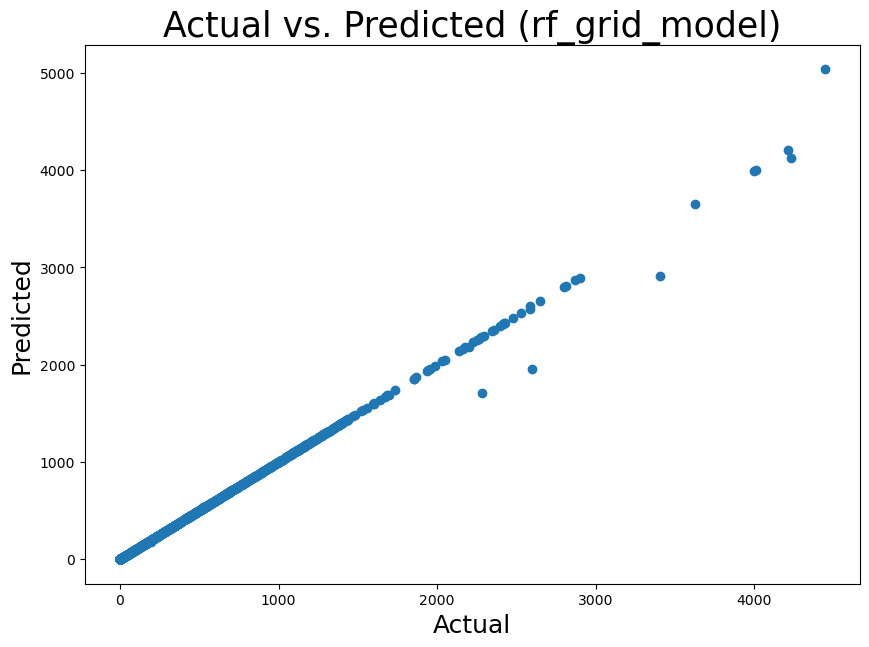

In [104]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 5, 10],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required at each leaf node
}

# Define the Random Forest regression model
rf_model = RandomForestRegressor(random_state=42)

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Perform grid search
grid_search.fit(X_train, y_train)

# Get the best model
best_rf_model = grid_search.best_estimator_

# Make predictions
y_pred_rf_grid_model = best_rf_model.predict(X_test)

# Evaluate the model
mse_rf_grid_model = mean_squared_error(y_test, y_pred_rf_grid_model)
print("Random Forest Regression Metrics (with GridSearchCV):")
print(f"Mean Squared Error (rf_grid_model): {mse_rf_grid_model}")

r2_rf_grid_model = r2_score(y_test, y_pred_rf_grid_model)
print(f"R-squared Score (rf_grid_model): {r2_rf_grid_model}")

# Print the best parameters found by GridSearchCV
print("Best parameters found by GridSearchCV:")
print(grid_search.best_params_)

# Print MAE (Mean Absolute Error)
print("MAE_rf_grid_model:")
print("Train_rf_grid_model:", mean_absolute_error(y_train, best_rf_model.predict(X_train)))
print("Test_rf_grid_model:", mean_absolute_error(y_test, y_pred_rf_grid_model))
print("====================================")

# Print MSE (Mean Squared Error)
print("MSE_rf_grid_model:")
print("Train_rf_grid_model:", mean_squared_error(y_train, best_rf_model.predict(X_train)))
print("Test_rf_grid_model:", mse_rf_grid_model)
print("====================================")

# Print RMSE (Root Mean Squared Error)
print("RMSE_rf_grid_model:")
print("Train_rf_grid_model:", np.sqrt(mean_squared_error(y_train, best_rf_model.predict(X_train))))
print("Test_rf_grid_model:", np.sqrt(mse_rf_grid_model))
print("====================================")

# Print R2 SCORE
print("R2_SCORE_rf_grid_model:")
print("Train_rf_grid_model:", r2_score(y_train, best_rf_model.predict(X_train)))
print("Test_rf_grid_model:", r2_rf_grid_model)
print("====================================")

# Calculate and print MAPE (Mean Absolute Percentage Error)
mape_train_rf_grid_model = np.mean(np.abs((y_train - best_rf_model.predict(X_train)) / y_train)) * 100
print("MAPE_rf_grid_model - Mean Absolute Percentage Error:")
print("Train_rf_grid_model:", mape_train_rf_grid_model)
print("Test_rf_grid_model:", np.mean(np.abs((y_test - y_pred_rf_grid_model) / y_test)) * 100)

# Plot actual vs predicted value
plt.figure(figsize=(10, 7))
plt.title("Actual vs. Predicted (rf_grid_model)", fontsize=25)
plt.xlabel("Actual", fontsize=18)
plt.ylabel("Predicted", fontsize=18)
plt.scatter(x=y_test, y=y_pred_rf_grid_model)
plt.show()

#### 6. XGBoost

XGBoost Regression Metrics (xgb_model):
Mean Squared Error (xgb_model): 101.67623558259646
R-squared Score (xgb_model): 0.9985364293904591
MAE_xgb_model:
Train_xgb_model: 0.15340626123694595
Test_xgb_model: 0.38814677128366615
MSE_xgb_model:
Train_xgb_model: 0.4947120089367544
Test_xgb_model: 101.67623558259646
RMSE_xgb_model:
Train_xgb_model: 0.7033576678594997
Test_xgb_model: 10.083463471575453
R2_SCORE_xgb_model:
Train_xgb_model: 0.9999924882520841
Test_xgb_model: 0.9985364293904591
MAPE_xgb_model - Mean Absolute Percentage Error:
Train_xgb_model: inf
Test_xgb_model: inf


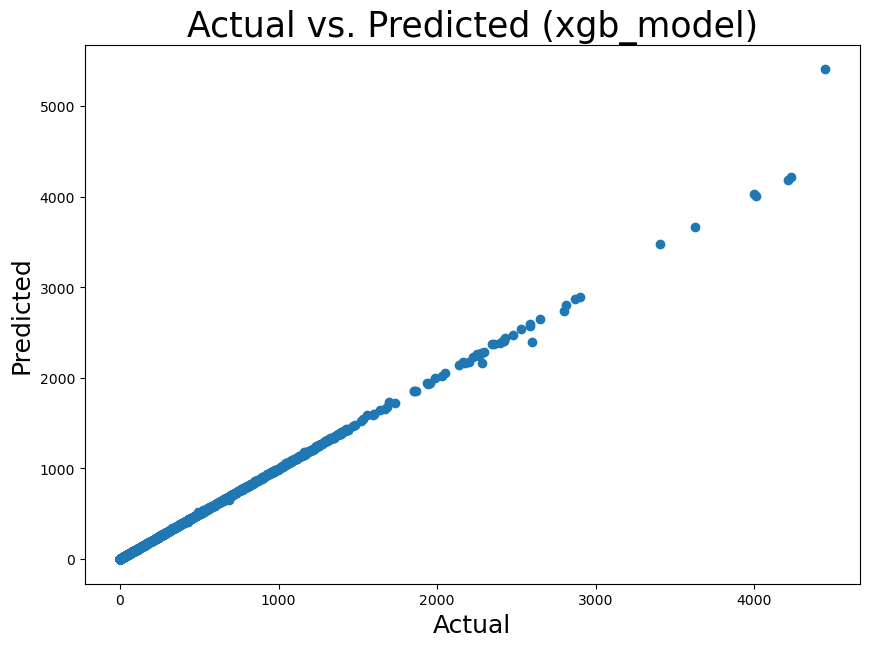

In [105]:
# Define the XGBoost regression model
xgb_model = XGBRegressor(random_state=42)

# Train the XGBoost regression model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb_model = xgb_model.predict(X_test)

# Evaluate the model
mse_xgb_model = mean_squared_error(y_test, y_pred_xgb_model)
print("XGBoost Regression Metrics (xgb_model):")
print(f"Mean Squared Error (xgb_model): {mse_xgb_model}")

r2_xgb_model = r2_score(y_test, y_pred_xgb_model)
print(f"R-squared Score (xgb_model): {r2_xgb_model}")

# Print MAE (Mean Absolute Error)
print("MAE_xgb_model:")
print("Train_xgb_model:", mean_absolute_error(y_train, xgb_model.predict(X_train)))
print("Test_xgb_model:", mean_absolute_error(y_test, y_pred_xgb_model))
print("====================================")

# Print MSE (Mean Squared Error)
print("MSE_xgb_model:")
print("Train_xgb_model:", mean_squared_error(y_train, xgb_model.predict(X_train)))
print("Test_xgb_model:", mse_xgb_model)
print("====================================")

# Print RMSE (Root Mean Squared Error)
print("RMSE_xgb_model:")
print("Train_xgb_model:", np.sqrt(mean_squared_error(y_train, xgb_model.predict(X_train))))
print("Test_xgb_model:", np.sqrt(mse_xgb_model))
print("====================================")

# Print R2 SCORE
print("R2_SCORE_xgb_model:")
print("Train_xgb_model:", r2_score(y_train, xgb_model.predict(X_train)))
print("Test_xgb_model:", r2_xgb_model)
print("====================================")

# Calculate and print MAPE (Mean Absolute Percentage Error)
mape_train_xgb_model = np.mean(np.abs((y_train - xgb_model.predict(X_train)) / y_train)) * 100
print("MAPE_xgb_model - Mean Absolute Percentage Error:")
print("Train_xgb_model:", mape_train_xgb_model)
print("Test_xgb_model:", np.mean(np.abs((y_test - y_pred_xgb_model) / y_test)) * 100)

# Plot actual vs predicted value
plt.figure(figsize=(10, 7))
plt.title("Actual vs. Predicted (xgb_model)", fontsize=25)
plt.xlabel("Actual", fontsize=18)
plt.ylabel("Predicted", fontsize=18)
plt.scatter(x=y_test, y=y_pred_xgb_model)
plt.show()

#### 7. XGBoost with Grid Search

XGBoost Regression Metrics (with GridSearchCV) (best_xgb_model_grid):
Mean Squared Error (best_xgb_model_grid): 79.67327537581629
R-squared Score (best_xgb_model_grid): 0.9988531492778253
Best parameters found by GridSearchCV:
{'learning_rate': 0.03, 'max_depth': 4, 'n_estimators': 900}
MAE_best_xgb_model_grid:
Train_best_xgb_model_grid: 0.22436817780586615
Test_best_xgb_model_grid: 0.4209922471507071
MSE_best_xgb_model_grid:
Train_best_xgb_model_grid: 1.2985418627904075
Test_best_xgb_model_grid: 79.67327537581629
RMSE_best_xgb_model_grid:
Train_best_xgb_model_grid: 1.139535810227308
Test_best_xgb_model_grid: 8.925988761802039
R2_SCORE_best_xgb_model_grid:
Train_best_xgb_model_grid: 0.9999802828333347
Test_best_xgb_model_grid: 0.9988531492778253
MAPE_best_xgb_model_grid - Mean Absolute Percentage Error:
Train_best_xgb_model_grid: inf
Test_best_xgb_model_grid: inf


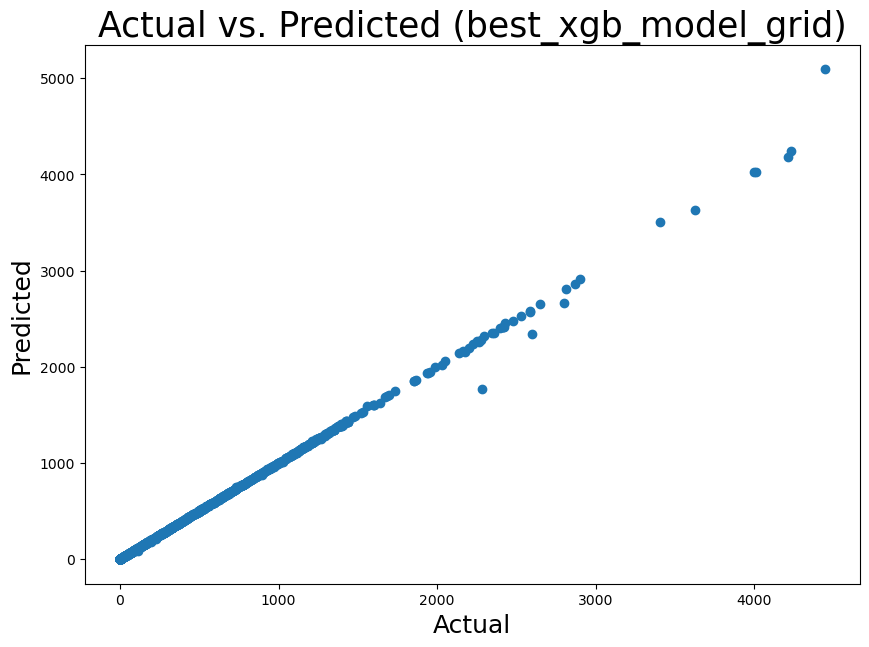

In [106]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators':  [700, 800, 900],  # Number of boosting rounds
    'max_depth': [2, 4, 6], # Maximum depth of the tree
    'learning_rate': [0.01, 0.02, 0.03]  # Step size shrinkage used in update to prevents overfitting
}

# Define the XGBoost regression model
xgb_model = XGBRegressor(random_state=42)

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Perform grid search
grid_search.fit(X_train, y_train)

# Get the best model
best_xgb_model_grid = grid_search.best_estimator_

# Make predictions
y_pred_xgb_grid_model = best_xgb_model_grid.predict(X_test)

# Evaluate the model
mse_xgb_grid_model = mean_squared_error(y_test, y_pred_xgb_grid_model)
print("XGBoost Regression Metrics (with GridSearchCV) (best_xgb_model_grid):")
print(f"Mean Squared Error (best_xgb_model_grid): {mse_xgb_grid_model}")

r2_xgb_grid_model = r2_score(y_test, y_pred_xgb_grid_model)
print(f"R-squared Score (best_xgb_model_grid): {r2_xgb_grid_model}")

# Print the best parameters found by GridSearchCV
print("Best parameters found by GridSearchCV:")
print(grid_search.best_params_)

# Print MAE (Mean Absolute Error)
print("MAE_best_xgb_model_grid:")
print("Train_best_xgb_model_grid:", mean_absolute_error(y_train, best_xgb_model_grid.predict(X_train)))
print("Test_best_xgb_model_grid:", mean_absolute_error(y_test, y_pred_xgb_grid_model))
print("====================================")

# Print MSE (Mean Squared Error)
print("MSE_best_xgb_model_grid:")
print("Train_best_xgb_model_grid:", mean_squared_error(y_train, best_xgb_model_grid.predict(X_train)))
print("Test_best_xgb_model_grid:", mse_xgb_grid_model)
print("====================================")

# Print RMSE (Root Mean Squared Error)
print("RMSE_best_xgb_model_grid:")
print("Train_best_xgb_model_grid:", np.sqrt(mean_squared_error(y_train, best_xgb_model_grid.predict(X_train))))
print("Test_best_xgb_model_grid:", np.sqrt(mse_xgb_grid_model))
print("====================================")

# Print R2 SCORE
print("R2_SCORE_best_xgb_model_grid:")
print("Train_best_xgb_model_grid:", r2_score(y_train, best_xgb_model_grid.predict(X_train)))
print("Test_best_xgb_model_grid:", r2_xgb_grid_model)
print("====================================")

# Calculate and print MAPE (Mean Absolute Percentage Error)
mape_train_xgb_grid_model = np.mean(np.abs((y_train - best_xgb_model_grid.predict(X_train)) / y_train)) * 100
print("MAPE_best_xgb_model_grid - Mean Absolute Percentage Error:")
print("Train_best_xgb_model_grid:", mape_train_xgb_grid_model)
print("Test_best_xgb_model_grid:", np.mean(np.abs((y_test - y_pred_xgb_grid_model) / y_test)) * 100)

# Plot actual vs predicted value
plt.figure(figsize=(10, 7))
plt.title("Actual vs. Predicted (best_xgb_model_grid)", fontsize=25)
plt.xlabel("Actual", fontsize=18)
plt.ylabel("Predicted", fontsize=18)
plt.scatter(x=y_test, y=y_pred_xgb_grid_model)
plt.show()


#### 8. ANN

In [108]:
# Define the ANN model
ann_model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.2),  # Add a dropout layer for regularization
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),  # Add another dropout layer
    tf.keras.layers.Dense(1)
])

# Compile the model
ann_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = ann_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
mse_ann = ann_model.evaluate(X_test, y_test)
print("Mean Squared Error (ann_model):", mse_ann)

# Make predictions on the test set
y_pred_ann_model = ann_model.predict(X_test)

# Calculate the coefficient of determination R^2
r2_ann_model = r2_score(y_test, y_pred_ann_model)
print("R-squared Score (ann_model):", r2_ann_model)

# Print MAE (Mean Absolute Error)
print("MAE_ann_model:")
print("Train_ann_model:", mean_absolute_error(y_train, ann_model.predict(X_train)))
print("Test_ann_model:", mean_absolute_error(y_test, y_pred_ann_model))
print("====================================")

# Print MSE (Mean Squared Error)
print("MSE_ann_model:")
print("Train_ann_model:", mean_squared_error(y_train, ann_model.predict(X_train)))
print("Test_ann_model:", mse_ann)
print("====================================")

# Print RMSE (Root Mean Squared Error)
print("RMSE_ann_model:")
print("Train_ann_model:", np.sqrt(mean_squared_error(y_train, ann_model.predict(X_train))))
print("Test_ann_model:", np.sqrt(mse_ann))
print("====================================")

# Print R2 SCORE
print("R2 SCORE_ann_model:")
print("Train_ann_model:", r2_score(y_train, ann_model.predict(X_train)))
print("Test_ann_model:", r2_ann_model)
print("====================================")

# Calculate and print MAPE (Mean Absolute Percentage Error)
#mape_train_ann_model = np.mean(np.abs((y_train - ann_model.predict(X_train)) / y_train)) * 100
#print("MAPE_ann_model - Mean Absolute Percentage Error:")
#print("Train_ann_model:", mape_train_ann_model)
#print("Test_ann_model:", np.mean(np.abs((y_test - y_pred_ann_model) / y_test)) * 100)

# Plot actual vs predicted value
#plt.figure(figsize=(10, 7))
#plt.title("Actual vs. Predicted (ann_model)", fontsize=25)
#plt.xlabel("Actual", fontsize=18)
#plt.ylabel("Predicted", fontsize=18)
#plt.scatter(x=y_test, y=y_pred_ann_model)
#plt.show()


Epoch 1/50
2251/2251 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 32056.9492 - val_loss: 6682.0806
Epoch 2/50
2251/2251 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 6410.0947 - val_loss: 3068.9639
Epoch 3/50
2251/2251 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 3652.7539 - val_loss: 1226.7849
Epoch 4/50
2251/2251 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 2205.1223 - val_loss: 872.4929
Epoch 5/50
2251/2251 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1958.8463 - val_loss: 531.2617
Epoch 6/50
2251/2251 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1850.3441 - val_loss: 478.5790
Epoch 7/50
2251/2251 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1682.4596 - val_loss: 407.0788
Epoch 8/50
2251/2251 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1583.4602 - val_loss: 319.9480
Epoch 9/50
2251/2251 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1315.7401 - val_loss: 257.8185
Epoch 10/50
2251/2251 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1222.2849 - val_loss: 187.4015
Epoch 11/50
2251/2251 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 12

#### Step 5. Interpretability

In [53]:
# List of model names
model_names = ['SVR', 'Linear Regression', 'Polynomial Regression', 'Random Forest With GridSearch', 'XGBoost With GridSearch', 'MLP Regressor']

# List of predicted values for each model
all_y_pred = [test_predict_svr_Ind, test_predict_reg_lin_Ind, test_predict_poly_Ind, y_pred_rf_grid_Ind_ppd, y_pred_xgb_grid_Ind, test_predict_mlp_Ind]

# List of metrics for each model
all_metrics = {
    'Model': model_names,
    'MAE': [mean_absolute_error(y_test_Ind, y_pred) for y_pred in all_y_pred],
    'MSE': [mean_squared_error(y_test_Ind, y_pred) for y_pred in all_y_pred],
    'RMSE': [np.sqrt(mean_squared_error(y_test_Ind, y_pred)) for y_pred in all_y_pred],
    'R2': [r2_score(y_test_Ind, y_pred) for y_pred in all_y_pred]
}

# Creating DataFrames
df_predictions = pd.DataFrame({f'y_pred_{model}': y_pred.flatten() for model, y_pred in zip(model_names, all_y_pred)})
df_metrics = pd.DataFrame(all_metrics)

# Display the DataFrames
print("\nPredictions DataFrame:")
(df_predictions)



Predictions DataFrame:


,y_pred_SVR,y_pred_Linear Regression,y_pred_Polynomial Regression,y_pred_Random Forest With GridSearch,y_pred_XGBoost With GridSearch,y_pred_MLP Regressor
0,0.099938,9.836843,-16.680481,0.000000,36.681015,2.676505
1,515.944323,743.665012,686.439117,815.248005,783.218628,846.639555
2,0.099969,33.559816,10.600983,0.000000,1.479686,12.972920
3,0.099986,23.699370,-13.351746,0.000000,1.479686,7.267987
4,-0.099868,21.219543,18.351898,0.000000,4.910512,0.706140
...,...,...,...,...,...,...
9993,-0.099976,-6.601691,-5.517426,0.000000,21.414846,-5.880099
9994,-0.099946,-10.791304,-3.566498,0.000000,-4.972651,-1.639418
9995,-0.099964,-24.435972,19.598083,0.000000,-0.999279,-2.873420
9996,1547.432918,2195.441457,1930.049896,1862.009297,1810.039551,1960.440306


In [54]:
print("\nMetrics DataFrame:")
df_metrics


Metrics DataFrame:


,Model,MAE,MSE,RMSE,R2
0,SVR,68.334079,97979.981696,313.017542,0.473433
1,Linear Regression,90.893776,90557.194803,300.927225,0.513325
2,Polynomial Regression,87.235533,88700.899750,297.826963,0.523301
3,Random Forest With GridSearch,71.807048,85727.278515,292.792210,0.539282
4,XGBoost With GridSearch,77.933222,86542.976836,294.181877,0.534898
5,MLP Regressor,79.818328,87224.554853,295.338035,0.531235


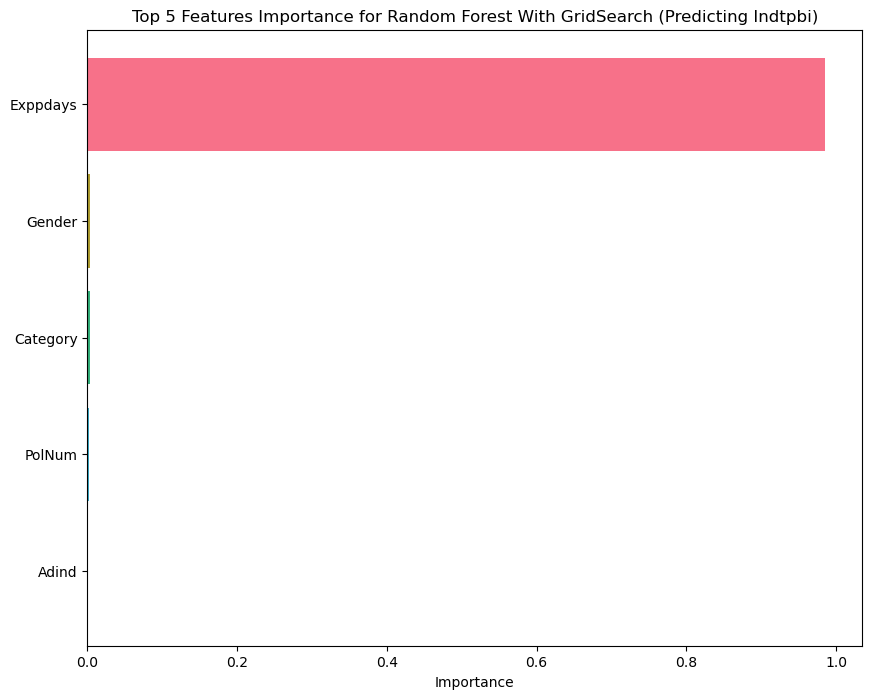

In [94]:
# Retrieve the best estimator
best_rf_model = best_rf_model_RF_GSCV.best_estimator_
feature_importances = best_rf_model.feature_importances_

# List of feature names
feature_names = ['Gender', 'Type', 'Category', 'Occupation', 'PolNum', 'CalYear', 'Age', 'Adind', 'Density', 'Bonus_processed', 'Exppdays',
                     'Numtpbi', 'Indtppd_processed', 'Numtppd']

# Sort the features by their importance
sorted_idx = np.argsort(feature_importances)

# Select the top 5 most important features
top_5_idx = sorted_idx[-5:]

# Define your custom color palette
custom_palette = sns.color_palette("husl", 5) 

# Create the plot
plt.figure(figsize=(10, 8))
plt.barh(range(5), feature_importances[top_5_idx][::-1], color=custom_palette)
plt.yticks(range(5), np.array(feature_names)[top_5_idx][::-1])  # Reverse the order for display
plt.xlabel('Importance')
plt.title('Top 5 Features Importance for Random Forest With GridSearch (Predicting Indtpbi)')
plt.gca().invert_yaxis()  # To display the highest importance at the top
plt.show()


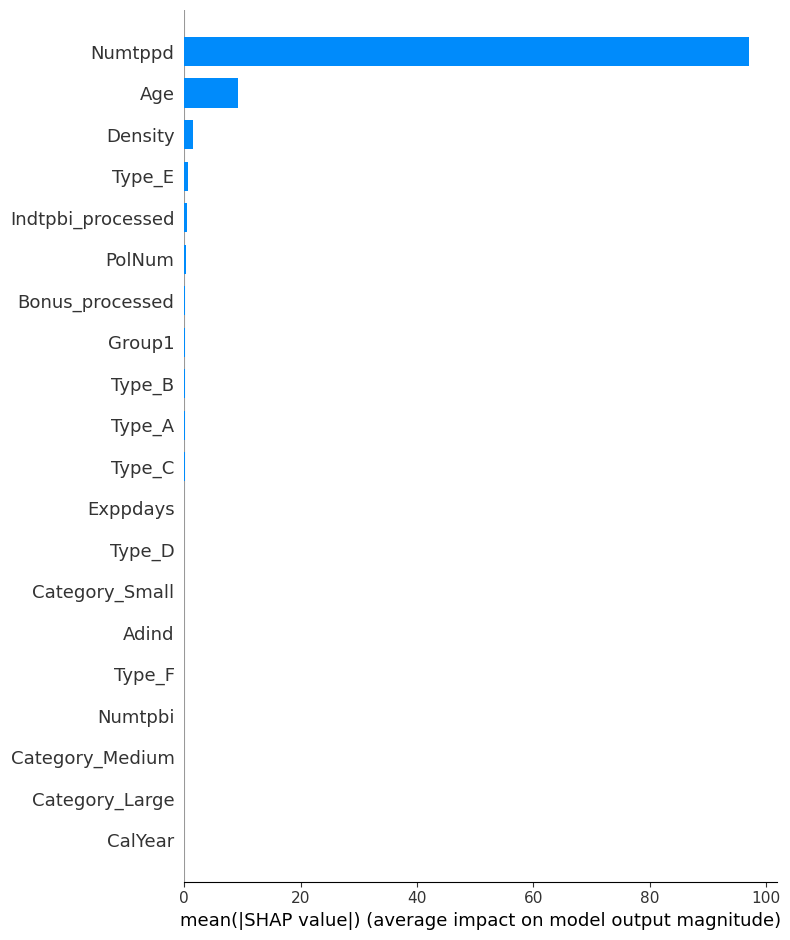

In [97]:
# One-hot encode categorical features
X_Ind_encoded = pd.get_dummies(X_Ind)

# Convert DataFrame to NumPy array
X_Ind_encoded_array = X_Ind_encoded.values

# Create a SHAP explainer
explainer = shap.TreeExplainer(best_rf_model)

# Calculate SHAP values
shap_values = explainer.shap_values(X_Ind_encoded_array)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, X_Ind_encoded_array, plot_type="bar", feature_names=X_Ind_encoded.columns)

In [98]:
# Create a DataFrame of SHAP values with feature names
shap_df = pd.DataFrame(shap_values, columns=X_Ind_encoded.columns)

# Display the DataFrame
shap_df.head()

,PolNum,CalYear,Age,Adind,Density,Bonus_processed,Exppdays,Group1,Numtpbi,Indtpbi_processed,Numtppd,Type_A,Type_B,Type_C,Type_D,Type_E,Type_F,Category_Large,Category_Medium,Category_Small
0,0.621193,0.003749,45.633964,0.045296,7.770560,1.112829,0.247661,-0.645801,0.062829,-1.507922,397.009826,-0.299076,0.476260,1.134762,-0.110123,2.026923,-0.020256,0.003057,0.000633,-0.068264
1,0.891399,0.003304,27.732731,-0.057148,7.538226,1.335201,0.133219,-0.853965,0.053343,-1.506408,381.825509,-0.298879,0.242920,-0.192693,-0.110029,-14.724421,-0.020296,-0.042045,-0.028812,-0.068197
2,0.741975,0.004364,26.987721,-0.147547,7.784135,0.971573,0.173171,-1.002432,0.059118,-1.615576,381.851341,-0.424879,0.248000,-0.192943,-0.106938,-15.016598,-0.027398,-0.042220,-0.007428,-0.067983
3,0.454342,0.004866,44.951579,0.047192,7.876224,-0.020014,0.259261,-0.844725,0.068615,-1.641922,396.221916,-0.318859,0.558643,1.135829,-0.143694,1.993240,-0.027362,0.016026,-0.047105,-0.067998
4,0.689371,0.003749,44.766590,0.066397,7.665335,1.114804,0.247661,-0.598271,0.062829,-1.545026,396.199899,-0.298910,0.476260,-0.169367,0.257009,2.044483,-0.020255,-0.079823,0.000633,-0.068264


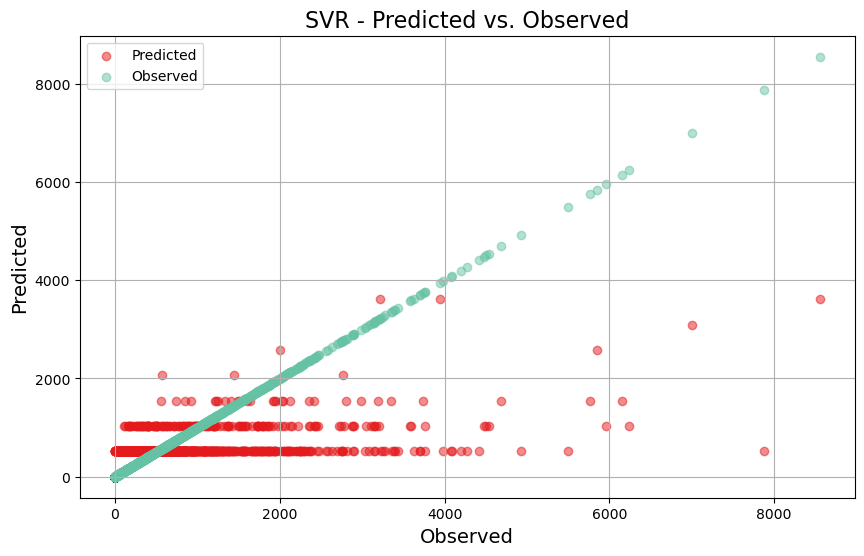

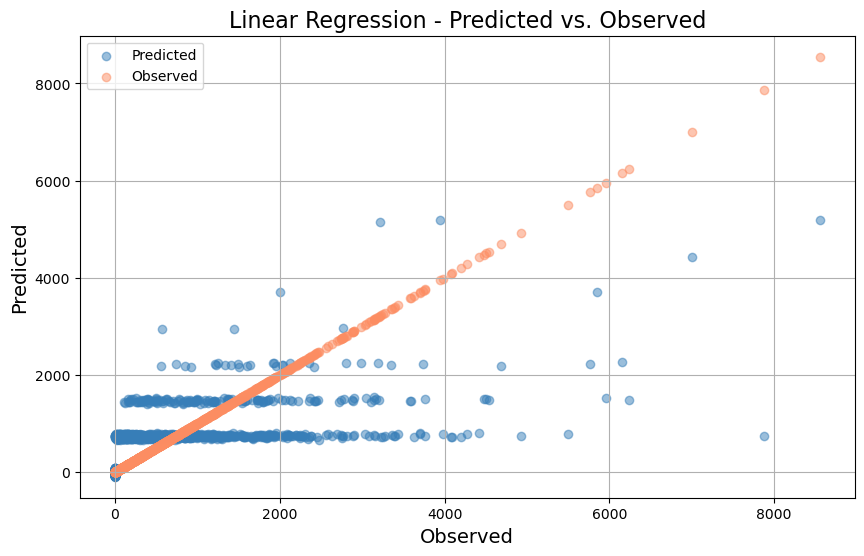

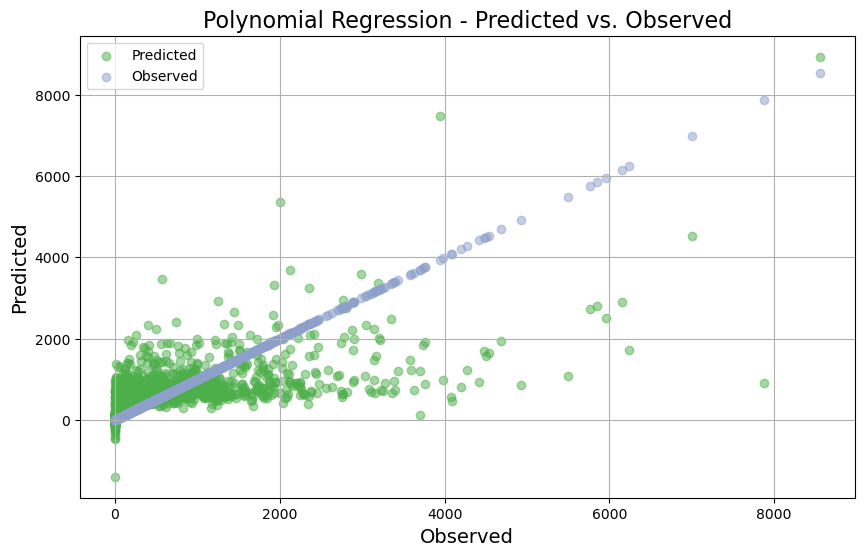

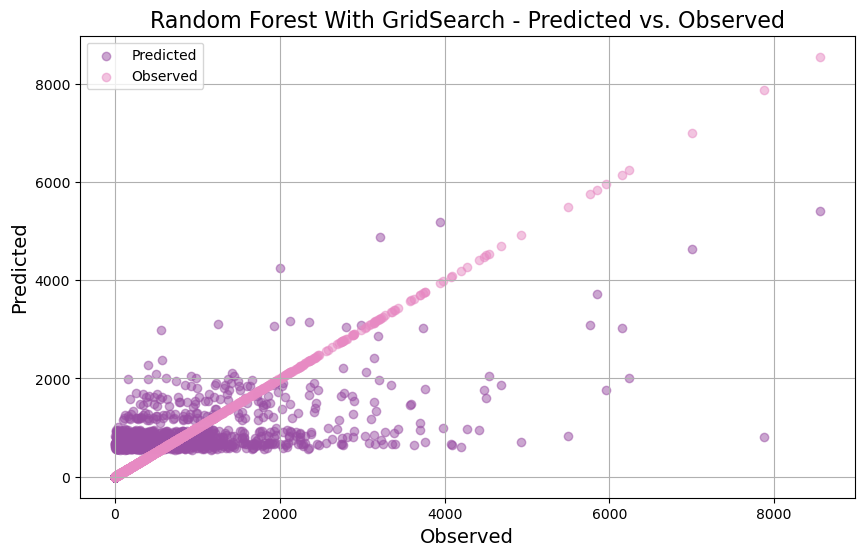

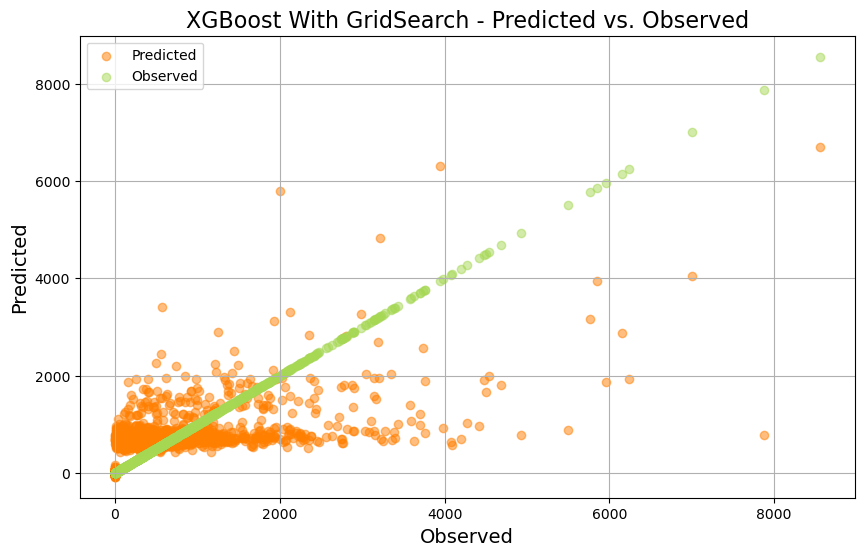

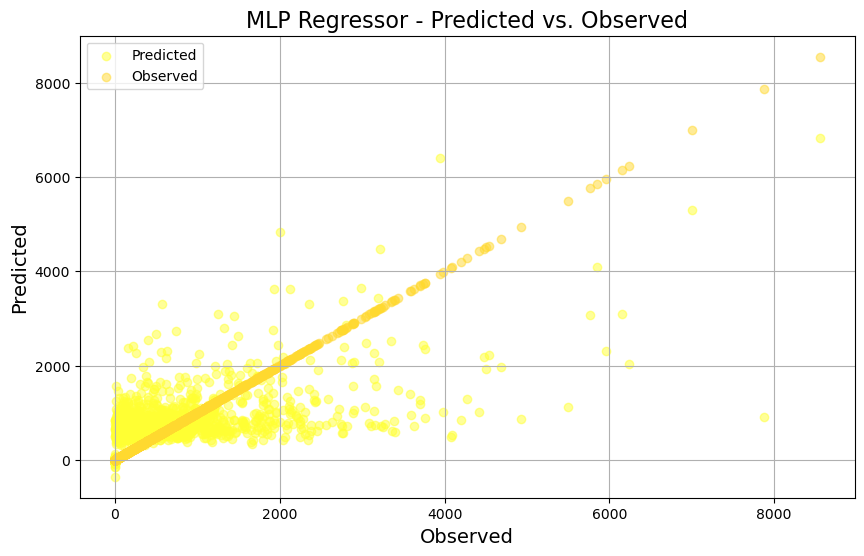

In [55]:
# Define palette of colors
palette_pred = sns.color_palette("Set1", n_colors=len(model_names))
palette_obs = sns.color_palette("Set2", n_colors=len(model_names))

# List of model names
model_names = ['SVR', 'Linear Regression', 'Polynomial Regression', 'Random Forest With GridSearch', 'XGBoost With GridSearch', 'MLP Regressor']

# List of predicted values for each model
all_y_pred = [test_predict_svr_Ind, test_predict_reg_lin_Ind, test_predict_poly_Ind, y_pred_rf_grid_Ind_ppd, y_pred_xgb_grid_Ind, test_predict_mlp_Ind]

# Create DataFrame for predictions
df_predictions = pd.DataFrame({f'y_pred_{model}': y_pred.flatten() for model, y_pred in zip(model_names, all_y_pred)})

# Add observed values to the DataFrame
df_predictions['Observed'] = y_test_Ind.values

# Plotting predictions vs. observed for each model with different colors for predicted and observed values
for i, model in enumerate(model_names):
    plt.figure(figsize=(10, 6))
    plt.scatter(df_predictions['Observed'], df_predictions[f'y_pred_{model}'], alpha=0.5, color=palette_pred[i], label='Predicted')
    plt.scatter(df_predictions['Observed'], df_predictions['Observed'], alpha=0.5, color=palette_obs[i], label='Observed')
    plt.title(f'{model} - Predicted vs. Observed', fontsize=16)
    plt.xlabel('Observed', fontsize=14)
    plt.ylabel('Predicted', fontsize=14)
    plt.grid(True)
    plt.legend()
    plt.show()

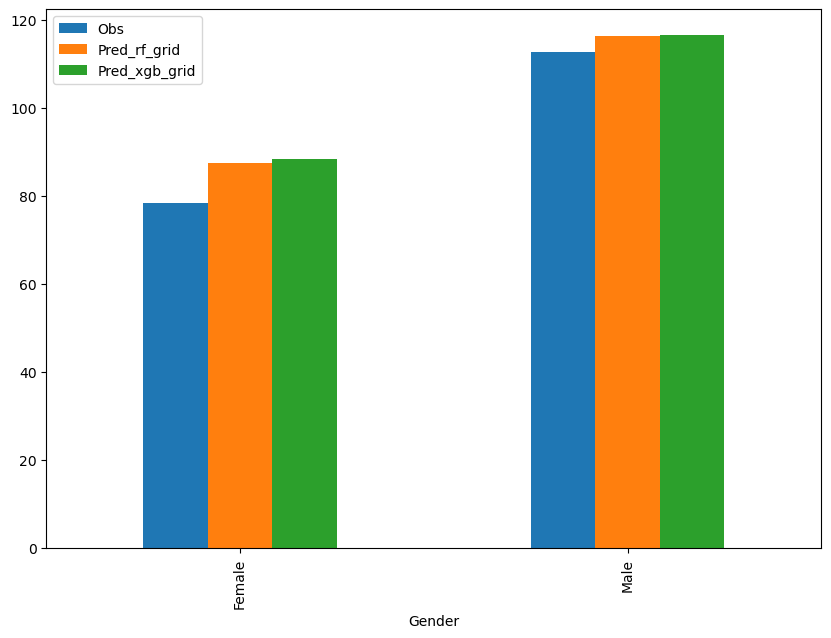

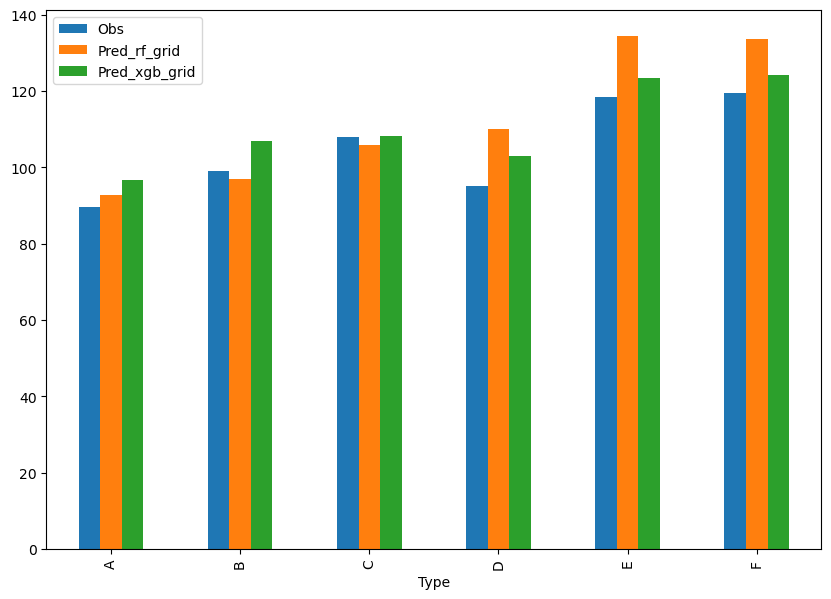

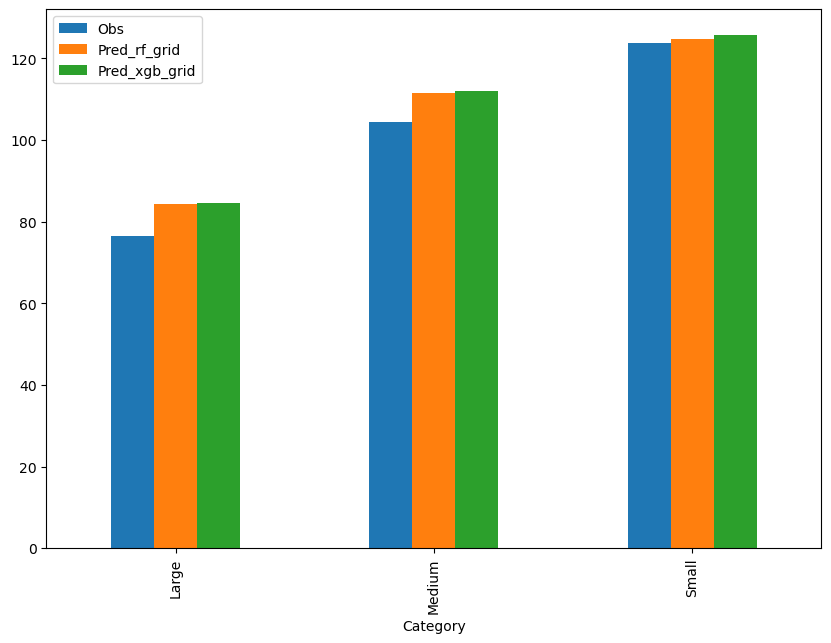

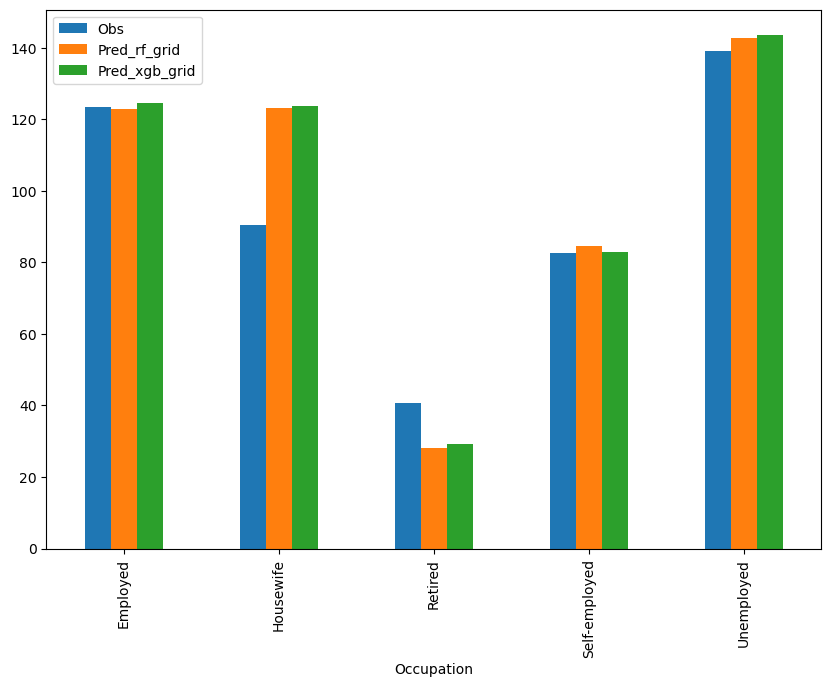

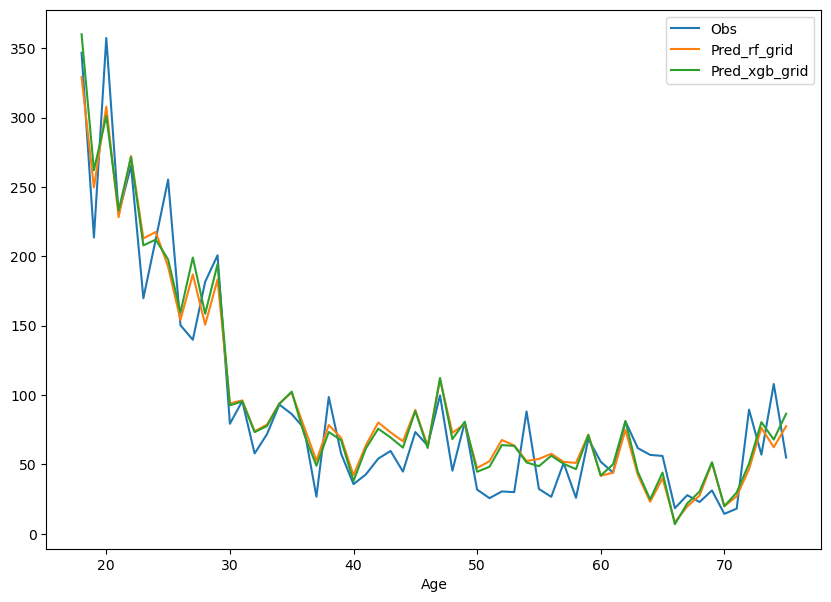

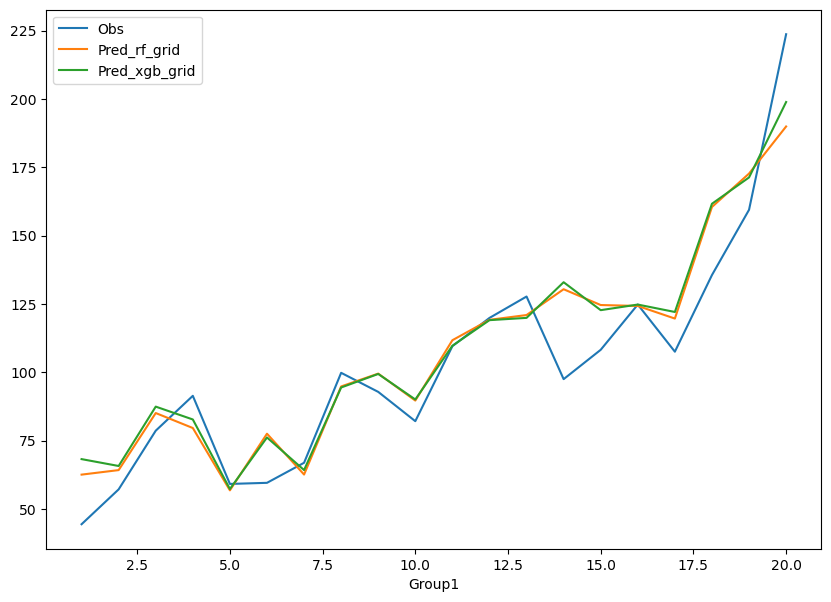

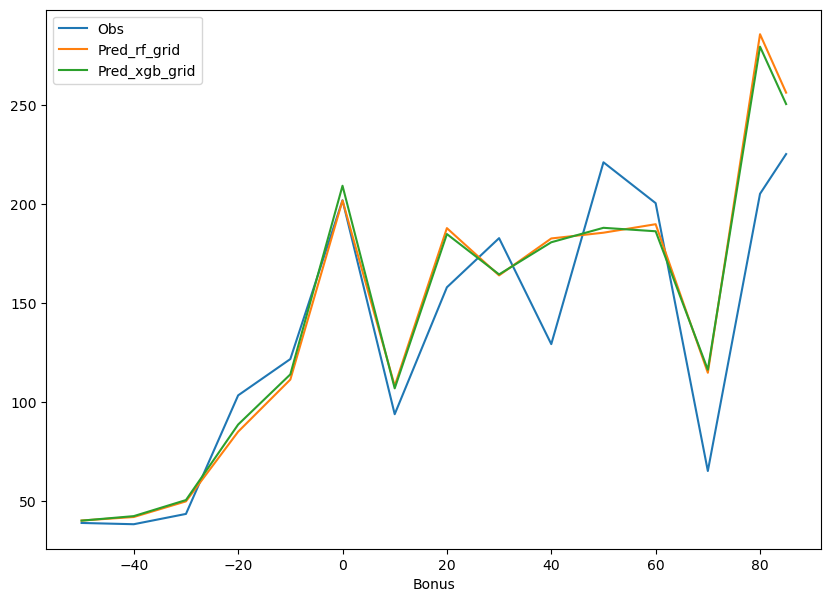

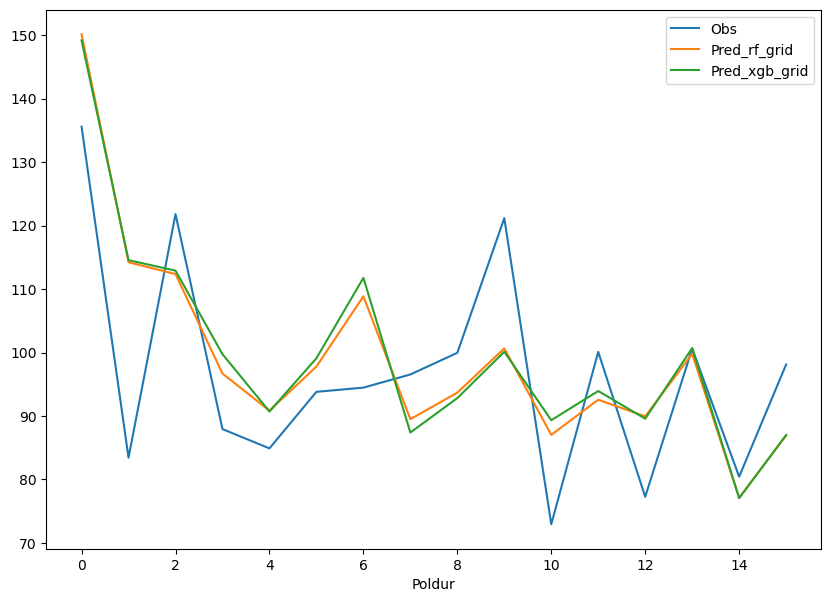

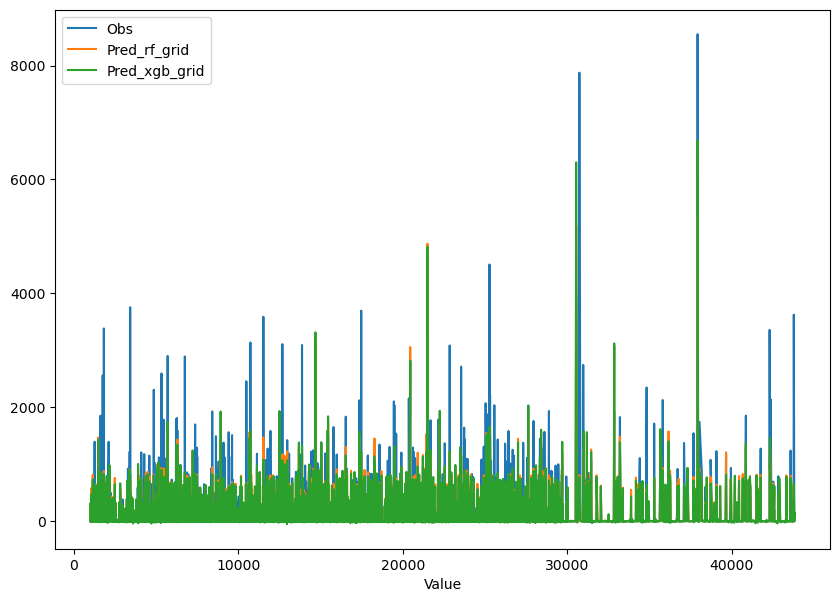

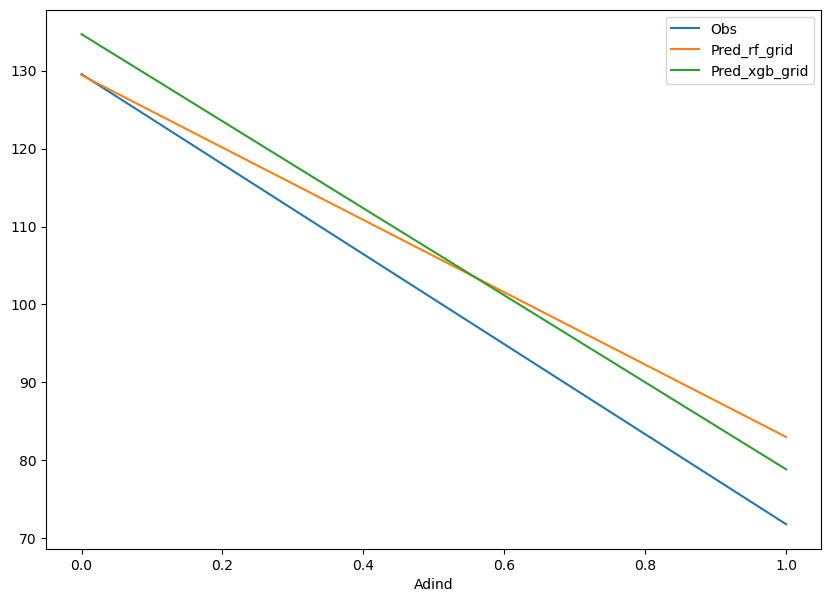

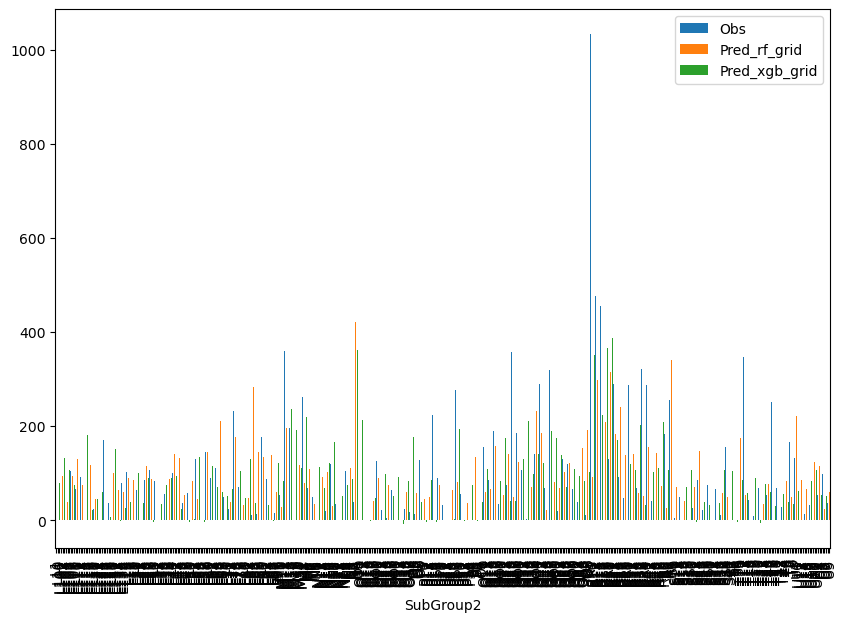

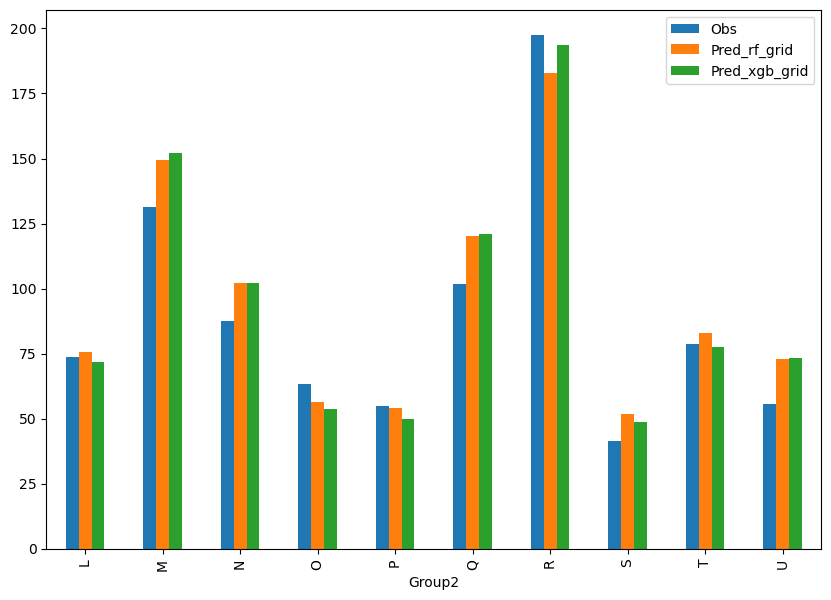

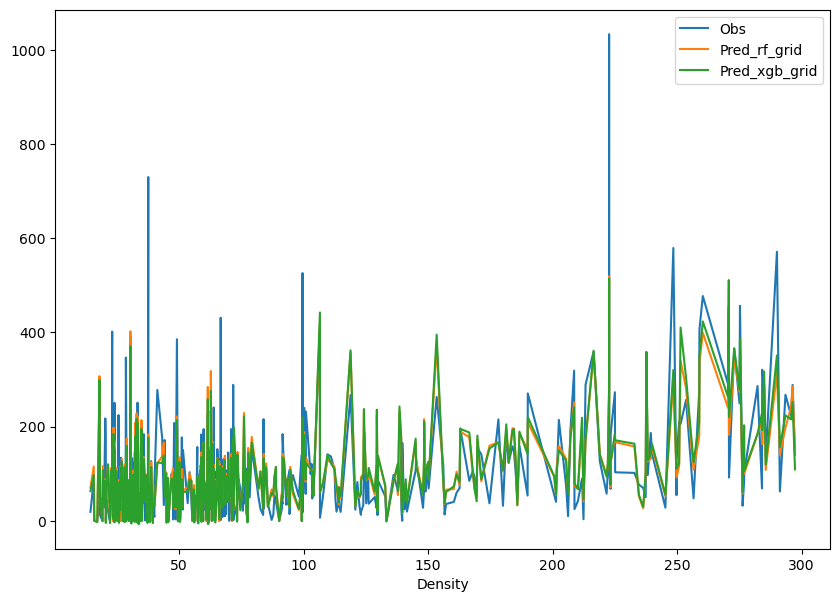

In [57]:
#Impact of target variable on the remaining variables
dataProv = pd.DataFrame(y_test_Ind.index)
dataProv.columns = ['index']
dataProv['Obs'] = np.array(y_test_Ind)
dataProv['Pred_rf_grid'] = y_pred_rf_grid_Ind_ppd 
dataProv['Pred_xgb_grid'] = y_pred_xgb_grid_Ind
# dataProv['Pred_xgb_grid'] = p_xgb_grid
dataProv.head()

dataFinale = training_data.copy().reset_index().merge(dataProv)
dataFinale.head()
palette = "deep"

for var in dataFinale.columns[3:16]:
    dataPlot = dataFinale.groupby([var])[['Obs', 'Pred_rf_grid', 'Pred_xgb_grid']].mean()
    
    if dataFinale[var].dtypes == 'O':
        # Créer un graphique à barres avec des couleurs de la palette
        ax = dataPlot.plot(kind='bar', figsize=(10, 7))
        ax.set_prop_cycle(color=sns.color_palette(palette))
    else:
        # Créer un graphique linéaire avec des couleurs de la palette
        ax = dataPlot.plot(figsize=(10, 7))
        ax.set_prop_cycle(color=sns.color_palette(palette))

plt.show()

#### Step B : Predicting Prime PPD

In [109]:
# List of model names
model_names = ['Linear Regression', 'Polynomial Regression', 'Random Forest', 'Random Forest With GridSearch', 'XGBoost', 'XGBoost With GridSearch', 'ANN']

# List of predicted values for each model
all_y_pred = [test_predict_reg_lin, test_predict_poly, test_predict_rf_model, y_pred_rf_grid_model, y_pred_xgb_model, y_pred_xgb_grid_model, y_pred_ann_model]

# List of true values for comparison
y_true = y_test  # Assuming y_test contains the true values

# List of metrics for each model
all_metrics = {
    'Model': model_names,
    'MAE': [mean_absolute_error(y_true, y_pred) for y_pred in all_y_pred],
    'MSE': [mean_squared_error(y_true, y_pred) for y_pred in all_y_pred],
    'RMSE': [np.sqrt(mean_squared_error(y_true, y_pred)) for y_pred in all_y_pred],
    'R2': [r2_score(y_true, y_pred) for y_pred in all_y_pred]
}

# Debugging: Print shapes of all_y_pred
for i, y_pred in enumerate(all_y_pred):
    print(f'Shape of y_pred_{model_names[i]}: {y_pred.shape}')

# Creating DataFrames
df_predictions = pd.DataFrame({f'y_pred_{model}': y_pred.flatten() for model, y_pred in zip(model_names, all_y_pred)})
df_metrics = pd.DataFrame(all_metrics)

# Display the DataFrames
print("\nPredictions DataFrame:")
(df_predictions)

Shape of y_pred_Linear Regression: (10003,)
Shape of y_pred_Polynomial Regression: (10003,)
Shape of y_pred_Random Forest: (10003,)
Shape of y_pred_Random Forest With GridSearch: (10003,)
Shape of y_pred_XGBoost: (10003,)
Shape of y_pred_XGBoost With GridSearch: (10003,)
Shape of y_pred_ANN: (10003, 1)

Predictions DataFrame:


,y_pred_Linear Regression,y_pred_Polynomial Regression,y_pred_Random Forest,y_pred_Random Forest With GridSearch,y_pred_XGBoost,y_pred_XGBoost With GridSearch,y_pred_ANN
0,-9.292514,-3.410605e-13,0.000000,0.000000,0.001428,-0.002468,0.415121
1,701.372277,5.694124e+02,569.252719,569.252719,570.997742,571.009521,587.257874
2,-7.281855,1.136868e-13,0.000000,0.000000,0.001359,-0.000320,0.401984
3,-12.693154,-1.364242e-12,0.000000,0.000000,0.001428,0.001026,0.265916
4,-8.458021,1.705303e-13,0.000000,0.000000,0.001428,-0.000350,0.305245
...,...,...,...,...,...,...,...
9998,-6.978366,1.136868e-13,0.000000,0.000000,0.001359,-0.002468,0.387694
9999,-3.727110,4.547474e-13,0.000000,0.000000,0.001359,-0.002693,0.363420
10000,-9.357432,5.115908e-13,0.000000,0.000000,0.001428,-0.003226,0.233145
10001,200.606354,1.705303e-13,0.000000,0.000000,0.022022,-1.112706,4.273314


In [110]:
print("\nMetrics DataFrame:")
(df_metrics)


Metrics DataFrame:


,Model,MAE,MSE,RMSE,R2
0,Linear Regression,2.725180e+01,1.036499e+04,1.018086e+02,0.850802
1,Polynomial Regression,7.260327e-13,1.103217e-23,3.321472e-12,1.000000
2,Random Forest,2.845830e-01,1.347071e+02,1.160634e+01,0.998061
3,Random Forest With GridSearch,2.845830e-01,1.347071e+02,1.160634e+01,0.998061
4,XGBoost,3.881468e-01,1.016762e+02,1.008346e+01,0.998536
5,XGBoost With GridSearch,4.209922e-01,7.967328e+01,8.925989e+00,0.998853
6,ANN,2.053562e+00,6.562634e+01,8.101009e+00,0.999055
